In [1]:
# Fix for module imports - add parent directory to Python path
import sys
import os

# Get the parent directory (project root) and add it to Python path
project_root = os.path.dirname(os.getcwd())
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Added to Python path: {project_root}")
print("Now you can import from modules package!")


Added to Python path: /Users/josiasmoukpe/Desktop/sep-forecasting-research
Now you can import from modules package!


In [2]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import psutil
import tensorflow as tf
from scipy.stats import pearsonr
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.models import Model

from modules.training.normlayer import NormalizeLayer
from modules.training.phase_manager import IsTraining

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

from modules.training.cme_modeling import ModelBuilder as MB

In [3]:
from modules.training.phase_manager import TrainingPhaseManager

# instantiate the model_builder
mb = MB()
pm = TrainingPhaseManager()  # Training phase manager

In [4]:
class TrainerV4:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()
        self.convergence_threshold = None

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)

        # Output layer
        outputs = Dense(self.output_dim)(x)
        outputs = NormalizeLayer(name='normalize_layer')(outputs)
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def generate_synthetic_data(self, num_points=200, noise_level=0.15):
        """
        Generate synthetic data where:
        - Features are random 2D points with coordinates between 0 and 1
        - Labels are distances from origin (0,0)
        - Middle distances are ~10x more frequent than extremes
        - noise_level controls the spread of the gaussian weighting (default 0.15)
        """
        # Generate more points than needed for sampling
        pool_size = num_points * 10
        features = np.random.uniform(0, 1, (pool_size, self.input_dim))

        # Calculate distances
        distances = np.sqrt(np.sum(features ** 2, axis=1))

        # Create weights favoring middle distances
        # Use a gaussian centered at ~0.75 (middle of the possible range 0 to √2)
        weights = np.exp(-((distances - 0.75) ** 2) / (2 * noise_level ** 2))

        # Normalize weights to probabilities
        weights = weights / np.sum(weights)

        # Sample indices according to weights
        selected_indices = np.random.choice(
            pool_size,
            size=num_points,
            p=weights,
            replace=False
        )

        # Select the points
        selected_features = features[selected_indices]
        selected_distances = distances[selected_indices]

        return selected_features, selected_distances.reshape(-1, 1)

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions."""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def train(self, loss_fn, num_points=2000, epochs=1000, batch_size=32, noise_level=0.15, verbose=1):
        # Generate synthetic data with specified noise level
        X_train, y_train = self.generate_synthetic_data(num_points=num_points, noise_level=noise_level)

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=loss_fn
        )

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.batch(batch_size)

        # Initialize tracking variables
        start_time = time.time()
        batch_times = []
        convergence_epoch = None
        convergence_time = None

        class ConvergenceCallback(tf.keras.callbacks.Callback):
            def __init__(self, trainer, threshold_factor=0.0007):
                super().__init__()
                self.trainer = trainer
                self.threshold_factor = threshold_factor
                self.first_loss = None
                self.convergence_reached = False
                self.batch_start_time = None

            def on_train_begin(self, logs=None):
                self.batch_start_time = time.time()

            def on_batch_end(self, batch, logs=None):
                batch_end_time = time.time()
                batch_duration = batch_end_time - self.batch_start_time
                batch_times.append(batch_duration)
                self.batch_start_time = batch_end_time

            def on_epoch_end(self, epoch, logs=None):
                current_loss = logs['loss']

                if self.first_loss is None:
                    self.first_loss = current_loss
                    self.trainer.convergence_threshold = self.first_loss * self.threshold_factor

                if not self.convergence_reached and current_loss <= self.trainer.convergence_threshold:
                    self.convergence_reached = True
                    nonlocal convergence_epoch, convergence_time
                    convergence_epoch = epoch + 1
                    convergence_time = time.time() - start_time

        convergence_callback = ConvergenceCallback(self)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[
                IsTraining(self.phase_manager),
                convergence_callback
            ]
        )

        # Final predictions
        predictions = self.model.predict(X_train)

        # Compute final correlation
        correlation = self.compute_pairwise_correlation(X_train, predictions)

        # Calculate and print metrics
        total_time = time.time() - start_time
        avg_batch_time = np.mean(batch_times)

        print("\nTraining Metrics:")
        print(f"Initial Loss: {history.history['loss'][0]:.6f}")
        print(f"Final Loss: {history.history['loss'][-1]:.6f}")
        print(f"Convergence Threshold: {self.convergence_threshold:.6f}")
        if convergence_epoch:
            print(f"Convergence Epoch: {convergence_epoch}")
            print(f"Loss at Convergence: {history.history['loss'][convergence_epoch - 1]:.6f}")
            print(f"Time to Convergence: {convergence_time:.2f} seconds")
        else:
            print("Model did not converge to threshold")
        print(f"Total Training Time: {total_time:.2f} seconds")
        print(f"Average Time per Batch: {avg_batch_time * 1000:.2f} ms")
        print(f"Final Correlation: {correlation:.4f}")
        print(f"Noise Level Used: {noise_level}")

        return history, correlation

    def plot_training_history(self, history):
        """Plot the training loss over epochs."""
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.axhline(y=self.convergence_threshold, color='r', linestyle='--',
                    label=f'Convergence Threshold ({self.convergence_threshold:.6f})')
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Use log scale to better see convergence
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_data_distribution(self, features, labels):
        """Plot the distribution of data points and their labels."""
        plt.figure(figsize=(15, 5))

        # Plot points in 2D space
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Origin')
        plt.title('Data Points Colored by Distance')
        plt.xlabel('X')
        plt.ylabel('Y')

        # Plot distance distribution
        plt.subplot(1, 3, 2)
        plt.hist(labels, bins=30, density=True)

        # Add the target distribution curve
        x = np.linspace(0, np.sqrt(2), 100)
        target_dist = np.exp(-((x - 0.75) ** 2) / (2 * 0.15 ** 2))
        target_dist = target_dist / np.max(target_dist) * plt.gca().get_ylim()[1]
        plt.plot(x, target_dist, 'r--', label='Target Distribution')
        plt.legend()

        plt.title('Distribution of Distances')
        plt.xlabel('Distance from Origin')
        plt.ylabel('Density')

        # Plot points with reference circles
        plt.subplot(1, 3, 3)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.5)

        # Add quarter circles at different radii
        for radius in [0.25, 0.5, 0.75, 1.0]:
            circle = plt.Circle((0, 0), radius, fill=False, color='red', alpha=0.3)
            plt.gca().add_artist(circle)

        plt.axis('equal')
        plt.title('Points with Reference Circles')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, features, labels, predictions):
        """Plot original data and model predictions."""
        plt.figure(figsize=(12, 5))

        # Original data
        plt.subplot(1, 2, 1)
        plt.scatter(features[:, 0], features[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Original Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Predictions
        plt.subplot(1, 2, 2)
        plt.scatter(predictions[:, 0], predictions[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Model Predictions')
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step

Training Metrics:
Initial Loss: 0.912207
Final Loss: 0.000123
Convergence Threshold: 0.000639
Convergence Epoch: 130
Loss at Convergence: 0.000637
Time to Convergence: 5.81 seconds
Total Training Time: 22.72 seconds
Average Time per Batch: 8.79 ms
Final Correlation: 0.5420
Noise Level Used: 0.5
Final Pairwise Correlation: 0.5420


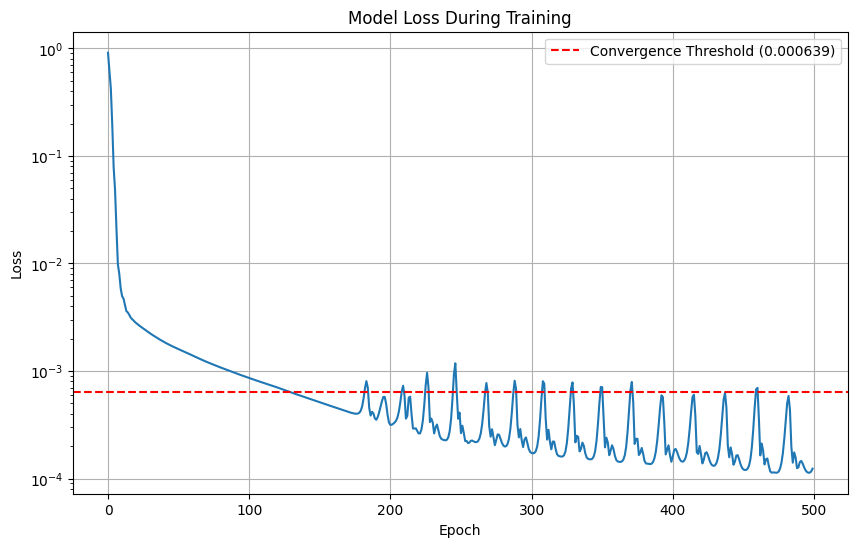

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step


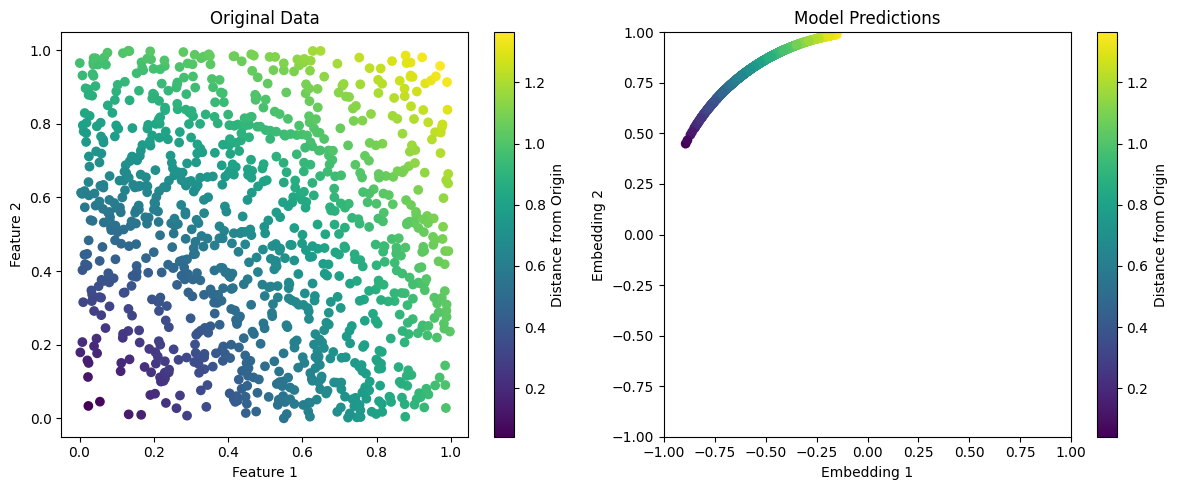

In [7]:
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_vec(y_true, y_pred, pm)  # Replace with appropriate loss function

noise_level = 0.50
trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(
    loss_fn=custom_loss, 
    num_points=5000, 
    noise_level=noise_level,
    epochs=500, 
    batch_size=1024,
    verbose=0
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

In [50]:
class TrainerV4_1:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2, embed_dim=2, use_normalize_layer=True):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim  # Now configurable for N dimensions
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.embed_dim = embed_dim  # Keep at 2 for visualization
        self.use_normalize_layer = use_normalize_layer
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()
        self.convergence_threshold = None

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))  # Use N-dimensional input
        x = inputs

        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)

        # Representation output (optionally normalized vector) - keep at 2D for visualization
        representation_output = Dense(self.embed_dim, name='representation_raw')(x)
        if self.use_normalize_layer:
            representation_output = NormalizeLayer(name='normalize_layer')(representation_output)
            rep_output_name = 'normalize_layer'
        else:
            rep_output_name = 'representation_raw'
        # Distance prediction from representation
        distance_output = Dense(1, name='distance_prediction')(representation_output)
        
        model = Model(inputs=inputs, outputs=[distance_output, representation_output])
        self.rep_output_name = rep_output_name  # Save for later use
        return model

    def generate_synthetic_data(self, num_points=200, noise_level=0.15):
        """
        Generate synthetic data where:
        - Features are random N-dimensional points with coordinates between 0 and 1
        - Labels are distances from origin (0,0,...,0)
        - Middle distances are ~10x more frequent than extremes
        - noise_level controls the spread of the gaussian weighting (default 0.15)
        """
        # Generate more points than needed for sampling
        pool_size = num_points * 10
        features = np.random.uniform(0, 1, (pool_size, self.input_dim))

        # Calculate distances from origin for N-dimensional space
        distances = np.sqrt(np.sum(features ** 2, axis=1))

        # Create weights favoring middle distances
        # For N dimensions, max possible distance is √N
        max_distance = np.sqrt(self.input_dim)
        # Center gaussian at middle of possible range (0 to √N)
        gaussian_center = max_distance * 0.5
        
        weights = np.exp(-((distances - gaussian_center) ** 2) / (2 * noise_level ** 2))

        # Normalize weights to probabilities
        weights = weights / np.sum(weights)

        # Sample indices according to weights
        selected_indices = np.random.choice(
            pool_size,
            size=num_points,
            p=weights,
            replace=False
        )

        # Select the points
        selected_features = features[selected_indices]
        selected_distances = distances[selected_indices]

        return selected_features, selected_distances.reshape(-1, 1)

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions."""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def compute_distance_metrics(self, y_true, y_pred):
        """Compute evaluation metrics for distance prediction."""
        mse = tf.keras.losses.mse(y_true, y_pred).numpy().mean()
        mae = tf.keras.losses.mae(y_true, y_pred).numpy().mean()
        # R-squared and RMSE removed as per instructions
        return {
            'mse': mse,
            'mae': mae,
        }

    def train(
        self, 
        representation_loss_fn=None, 
        distance_loss_weight=1.0, 
        representation_loss_weight=0.5, 
        representation_targets=None, 
        num_points=2000, 
        epochs=1000, 
        batch_size=32, 
        noise_level=0.15, 
        verbose=0):
        """
        Train the model with dual outputs: distance prediction and representation learning.
        
        Args:
            representation_loss_fn: Loss function for representation learning. If None, uses features as targets (autoencoder style)
            distance_loss_weight: Weight for distance prediction loss
            representation_loss_weight: Weight for representation learning loss  
            representation_targets: Target for representation learning. If None, uses input features
            num_points: Number of training points
            epochs: Number of training epochs
            batch_size: Batch size
            noise_level: Noise level for data generation
            verbose: Verbosity level
        """
        # Generate synthetic data with specified noise level
        X_train, y_distance = self.generate_synthetic_data(num_points=num_points, noise_level=noise_level)
        
        # Set representation targets
        if representation_targets is None:
            y_representation = X_train  # Autoencoder style - reconstruct input features
        else:
            y_representation = representation_targets
            
        # Set representation loss function
        if representation_loss_fn is None:
            representation_loss_fn = 'mse'  # Default to MSE for autoencoder style

        # Prepare loss, loss_weights, metrics, and targets dicts based on output names
        loss_dict = {
            'distance_prediction': 'mse',
            self.rep_output_name: representation_loss_fn
        }
        loss_weights_dict = {
            'distance_prediction': distance_loss_weight,
            self.rep_output_name: representation_loss_weight
        }
        metrics_dict = {
            'distance_prediction': ['mae'],
            self.rep_output_name: []
        }
        targets = {
            'distance_prediction': y_distance,
            self.rep_output_name: y_representation
        }

        # Compile model with multiple outputs and losses
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=loss_dict,
            loss_weights=loss_weights_dict,
            metrics=metrics_dict
        )

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, targets))
        train_dataset = train_dataset.batch(batch_size)

        # Initialize tracking variables
        start_time = time.time()
        batch_times = []
        convergence_epoch = None
        convergence_time = None

        class ConvergenceCallback(tf.keras.callbacks.Callback):
            def __init__(self, trainer, threshold_factor=0.0007):
                super().__init__()
                self.trainer = trainer
                self.threshold_factor = threshold_factor
                self.first_loss = None
                self.convergence_reached = False
                self.batch_start_time = None

            def on_train_begin(self, logs=None):
                self.batch_start_time = time.time()

            def on_batch_end(self, batch, logs=None):
                batch_end_time = time.time()
                batch_duration = batch_end_time - self.batch_start_time
                batch_times.append(batch_duration)
                self.batch_start_time = batch_end_time

            def on_epoch_end(self, epoch, logs=None):
                # Use total loss for convergence
                current_loss = logs['loss']

                if self.first_loss is None:
                    self.first_loss = current_loss
                    self.trainer.convergence_threshold = self.first_loss * self.threshold_factor

                if not self.convergence_reached and current_loss <= self.trainer.convergence_threshold:
                    self.convergence_reached = True
                    nonlocal convergence_epoch, convergence_time
                    convergence_epoch = epoch + 1
                    convergence_time = time.time() - start_time

        convergence_callback = ConvergenceCallback(self)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[
                IsTraining(self.phase_manager),
                convergence_callback
            ]
        )

        # Final predictions
        predictions = self.model.predict(X_train)
        distance_predictions = predictions[0]
        representation_predictions = predictions[1]

        # Compute evaluation metrics
        distance_metrics = self.compute_distance_metrics(y_distance, distance_predictions)
        correlation = self.compute_pairwise_correlation(X_train, representation_predictions)

        # Calculate and print metrics
        total_time = time.time() - start_time
        avg_batch_time = np.mean(batch_times)

        print("\nTraining Metrics:")
        print(f"Initial Total Loss: {history.history['loss'][0]:.6f}")
        print(f"Final Total Loss: {history.history['loss'][-1]:.6f}")
        print(f"Initial Distance Loss: {history.history['distance_prediction_loss'][0]:.6f}")
        print(f"Final Distance Loss: {history.history['distance_prediction_loss'][-1]:.6f}")
        # Print representation loss using the correct output name
        rep_loss_key = f"{self.rep_output_name}_loss"
        if rep_loss_key in history.history:
            print(f"Initial Representation Loss: {history.history[rep_loss_key][0]:.6f}")
            print(f"Final Representation Loss: {history.history[rep_loss_key][-1]:.6f}")
        else:
            print("Representation Loss: (not available)")
        print(f"Convergence Threshold: {self.convergence_threshold:.6f}")
        
        if convergence_epoch:
            print(f"Convergence Epoch: {convergence_epoch}")
            print(f"Loss at Convergence: {history.history['loss'][convergence_epoch - 1]:.6f}")
            print(f"Time to Convergence: {convergence_time:.2f} seconds")
        else:
            print("Model did not converge to threshold")
            
        print(f"Total Training Time: {total_time:.2f} seconds")
        print(f"Average Time per Batch: {avg_batch_time * 1000:.2f} ms")
        
        print("\nDistance Prediction Metrics:")
        print(f"MSE: {distance_metrics['mse']:.6f}")
        print(f"MAE: {distance_metrics['mae']:.6f}")
        
        print(f"\nRepresentation Quality:")
        print(f"Pairwise Correlation: {correlation:.4f}")
        print(f"Noise Level Used: {noise_level}")

        return history, distance_metrics, correlation, distance_predictions, representation_predictions, X_train, y_distance

    def plot_training_history(self, history):
        """Plot the training losses over epochs."""
        plt.figure(figsize=(15, 5))
        
        # Total loss
        plt.subplot(1, 3, 1)
        plt.plot(history.history['loss'])
        if self.convergence_threshold:
            plt.axhline(y=self.convergence_threshold, color='r', linestyle='--',
                        label=f'Convergence Threshold ({self.convergence_threshold:.6f})')
        plt.title('Total Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        # Removed log scale
        plt.grid(True)
        plt.legend()
        
        # Distance prediction loss
        plt.subplot(1, 3, 2)
        plt.plot(history.history['distance_prediction_loss'])
        plt.title('Distance Prediction Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        # Removed log scale
        plt.grid(True)
        
        # Representation loss
        plt.subplot(1, 3, 3)
        rep_loss_key = f"{self.rep_output_name}_loss"
        if rep_loss_key in history.history:
            plt.plot(history.history[rep_loss_key])
            plt.title('Representation Loss')
        else:
            plt.plot([])
            plt.title('Representation Loss (N/A)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        # Removed log scale
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_actual_vs_predicted(self, true_distances, predicted_distances):
        """Plot actual vs predicted distances with performance metrics."""
        plt.figure(figsize=(10, 8))
        
        # Main scatter plot
        plt.scatter(true_distances, predicted_distances, alpha=0.6, s=50)
        
        # Perfect prediction line
        min_dist = min(true_distances.min(), predicted_distances.min())
        max_dist = max(true_distances.max(), predicted_distances.max())
        plt.plot([min_dist, max_dist], [min_dist, max_dist], 'r--', linewidth=2, label='Perfect Prediction')
        
        # Calculate and display metrics
        residuals = true_distances.flatten() - predicted_distances.flatten()
        mse = np.mean(residuals**2)
        mae = np.mean(np.abs(residuals))
        
        # Add metrics to plot (no RMSE, no R²)
        metrics_text = f'MSE = {mse:.6f}\nMAE = {mae:.6f}'
        plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.xlabel('True Distance', fontsize=12)
        plt.ylabel('Predicted Distance', fontsize=12)
        plt.title('Distance Prediction: Actual vs Predicted', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Make plot square for better visualization
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    def plot_distance_predictions(self, features, true_distances, predicted_distances):
        """Plot comprehensive distance prediction analysis"""
        plt.figure(figsize=(12, 4))
        
        # Actual vs Predicted scatter plot
        plt.subplot(1, 2, 1)
        plt.scatter(true_distances, predicted_distances, alpha=0.6)
        min_dist = min(true_distances.min(), predicted_distances.min())
        max_dist = max(true_distances.max(), predicted_distances.max())
        plt.plot([min_dist, max_dist], [min_dist, max_dist], 'r--', label='Perfect Prediction')
        
        # Calculate metrics
        residuals = true_distances.flatten() - predicted_distances.flatten()
        mse = np.mean(residuals**2)
        mae = np.mean(np.abs(residuals))
        metrics_text = f'MSE = {mse:.6f}\nMAE = {mae:.6f}'
        plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.xlabel('True Distance')
        plt.ylabel('Predicted Distance')
        plt.title('Distance Prediction: Actual vs Predicted')
        plt.legend()
        plt.grid(True)
        
        # Error distribution
        plt.subplot(1, 2, 2)
        plt.hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black')
        plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
        plt.axvline(x=np.mean(residuals), color='orange', linestyle='--', label=f'Mean Error: {np.mean(residuals):.4f}')
        plt.xlabel('Prediction Error')
        plt.ylabel('Density')
        plt.title('Error Distribution')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_data_distribution(self, features, labels):
        """Plot the distribution of data points and their labels (adapted for N-D)."""
        plt.figure(figsize=(15, 5))

        # For N > 2, plot first two dimensions only
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Origin')
        plt.title(f'Data Points (First 2 of {self.input_dim} dims) Colored by Distance')
        plt.xlabel('X1')
        plt.ylabel('X2')

        # Plot distance distribution
        plt.subplot(1, 3, 2)
        plt.hist(labels, bins=30, density=True)

        # Add the target distribution curve
        max_distance = np.sqrt(self.input_dim)
        x = np.linspace(0, max_distance, 100)
        gaussian_center = max_distance * 0.5
        target_dist = np.exp(-((x - gaussian_center) ** 2) / (2 * 0.15 ** 2))
        target_dist = target_dist / np.max(target_dist) * plt.gca().get_ylim()[1]
        plt.plot(x, target_dist, 'r--', label='Target Distribution')
        plt.legend()

        plt.title(f'Distribution of Distances (N={self.input_dim})')
        plt.xlabel('Distance from Origin')
        plt.ylabel('Density')

        # Plot points with reference circles (first 2 dimensions)
        plt.subplot(1, 3, 3)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.5)

        # Add quarter circles at different radii (adjusted for N dimensions)
        max_2d_distance = np.sqrt(2)  # For visualization in 2D
        for radius in np.linspace(0.25, max_2d_distance, 4):
            circle = plt.Circle((0, 0), radius, fill=False, color='red', alpha=0.3)
            plt.gca().add_artist(circle)

        plt.axis('equal')
        plt.title(f'Points with Reference Circles (2D projection of {self.input_dim}D)')
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, features, labels, distance_predictions, representation_predictions):
        """Plot original data and representations with actual vs predicted. 
        No feature colored by predicted distance, no residual plot, no RMSE/R².
        Embeddings are always plotted, even if not normalized.
        """
        plt.figure(figsize=(16, 8))

        # Actual vs Predicted (prominent first plot)
        plt.subplot(2, 2, 1)
        plt.scatter(labels, distance_predictions, alpha=0.6, s=50)
        min_dist = min(labels.min(), distance_predictions.min())
        max_dist = max(labels.max(), distance_predictions.max())
        plt.plot([min_dist, max_dist], [min_dist, max_dist], 'r--', linewidth=2, label='Perfect Prediction')
        
        # Calculate metrics
        residuals = labels.flatten() - distance_predictions.flatten()
        mse = np.mean(residuals**2)
        mae = np.mean(np.abs(residuals))
        metrics_text = f'MSE = {mse:.6f}\nMAE = {mae:.6f}'
        plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=12, fontweight='bold')
        
        plt.xlabel('True Distance', fontsize=12)
        plt.ylabel('Predicted Distance', fontsize=12)
        plt.title('Distance Prediction: Actual vs Predicted', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Removed original data plot (was subplot(2,2,2))

        # Representation space (embedding)
        plt.subplot(2, 2, 3)
        plt.scatter(
            representation_predictions[:, 0], 
            representation_predictions[:, 1], 
            c=labels.flatten(), 
            cmap='viridis',
            alpha=0.6,
            s=50
        )
        plt.colorbar(label='True Distance')
        plt.title(
            'Learned Representation Space'
            + ('' if self.use_normalize_layer else ' (Not Normalized)')
        )
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        # Only set axis limits if normalized
        if self.use_normalize_layer:
            plt.xlim(-1, 1)
            plt.ylim(-1, 1)
        plt.grid(True)
        
        # Error distribution
        plt.subplot(2, 2, 4)
        plt.hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black')
        plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
        plt.axvline(
            x=np.mean(residuals), 
            color='orange', 
            linestyle='--', 
            label=f'Mean Error: {np.mean(residuals):.4f}'
        )
        plt.xlabel('Prediction Error')
        plt.ylabel('Density')
        plt.title('Error Distribution')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step

Training Metrics:
Initial Total Loss: 3.036405
Final Total Loss: 0.223297
Initial Distance Loss: 1.996150
Final Distance Loss: 0.015741
Initial Representation Loss: 1.012350
Final Representation Loss: 0.207304
Convergence Threshold: 0.002125
Model did not converge to threshold
Total Training Time: 14.92 seconds
Average Time per Batch: 9.08 ms

Distance Prediction Metrics:
MSE: 0.015686
MAE: 0.099827

Representation Quality:
Pairwise Correlation: 0.0624
Noise Level Used: 0.15
Final Pairwise Correlation: 0.0624
Distance Prediction MAE: 0.099827


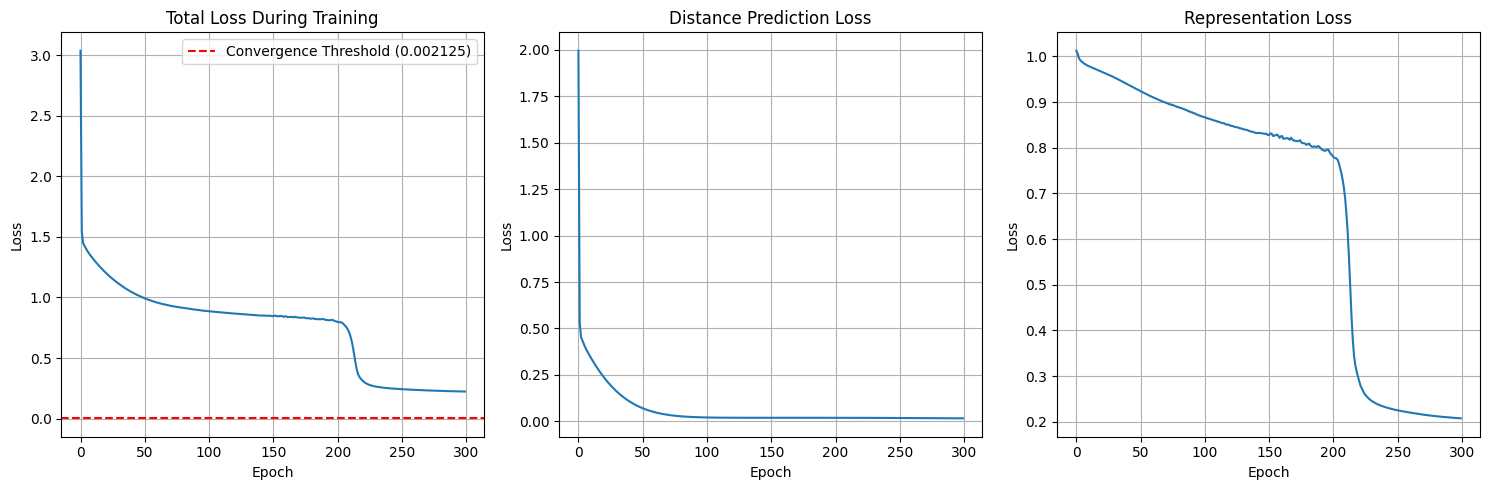

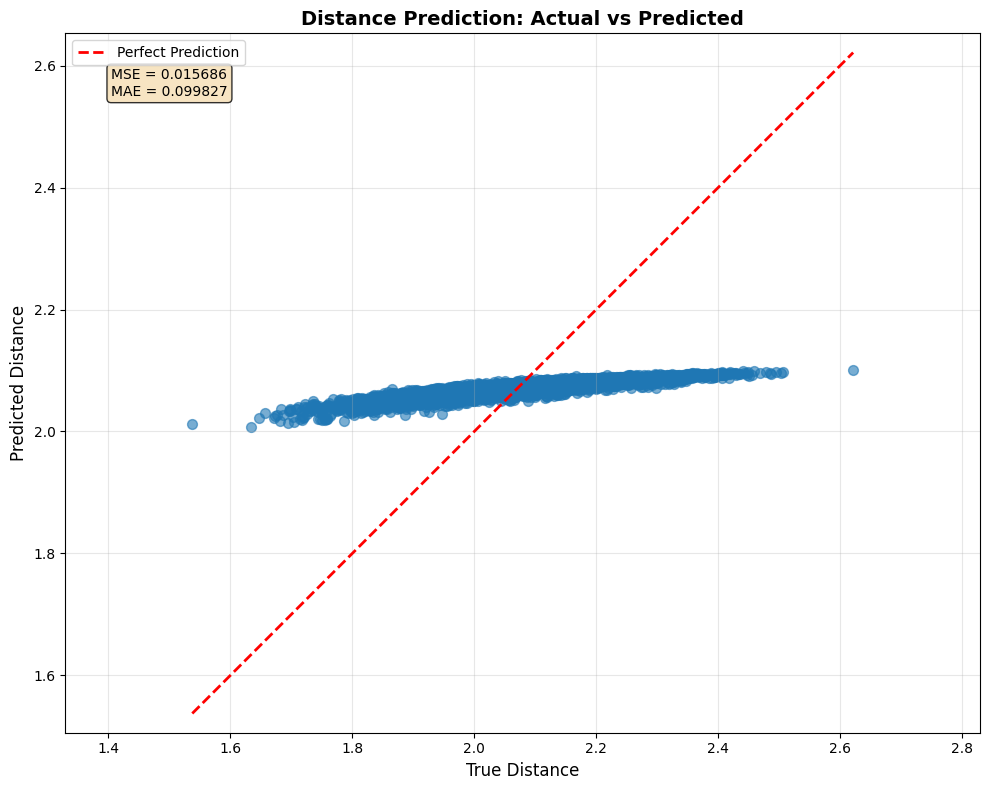

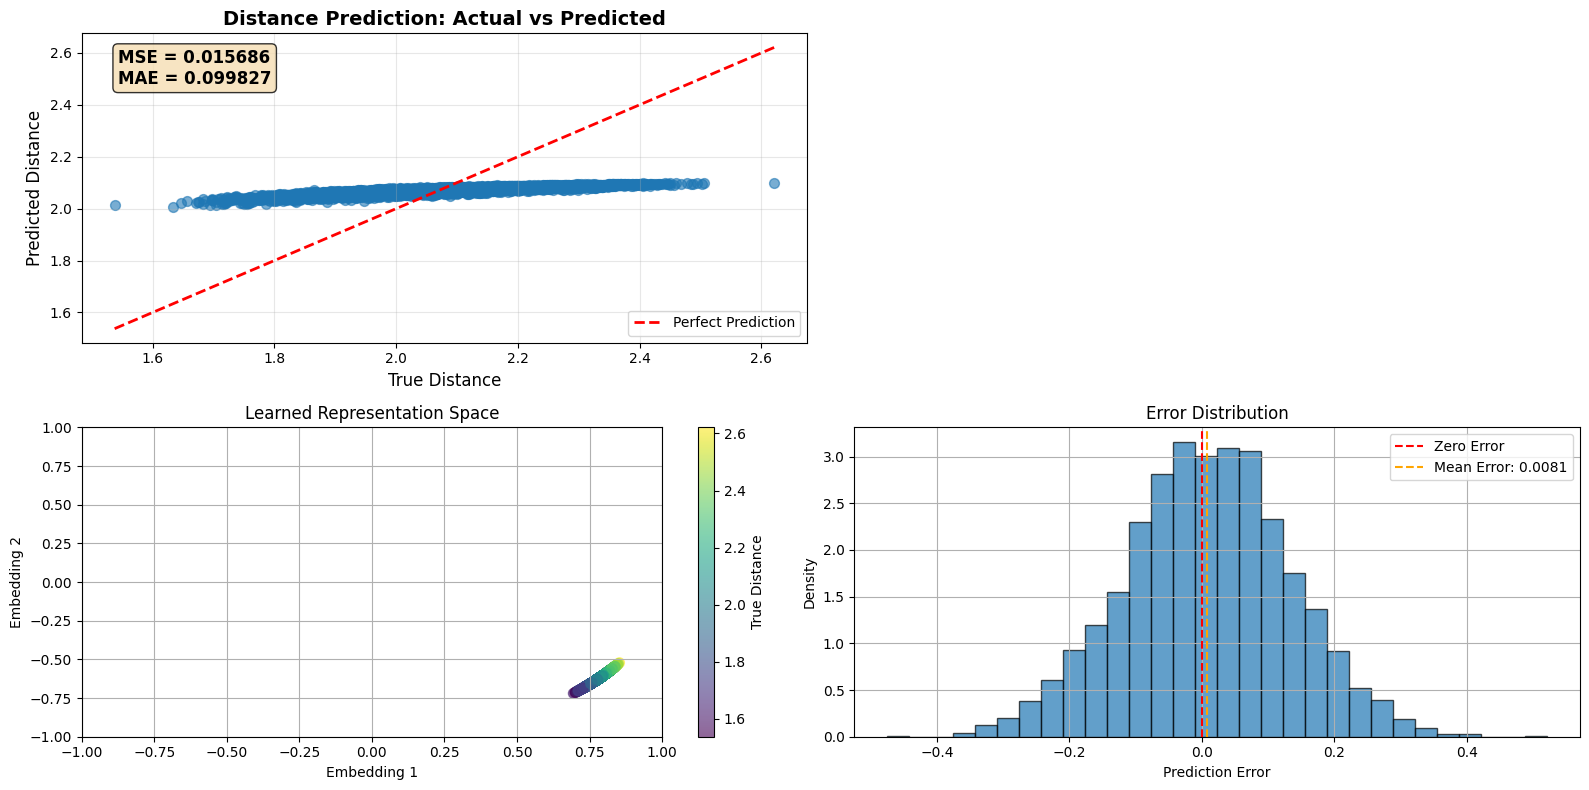

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step

Test Set Performance:
Test Pairwise Correlation: 0.0659
Test Distance Prediction MAE: 0.104323


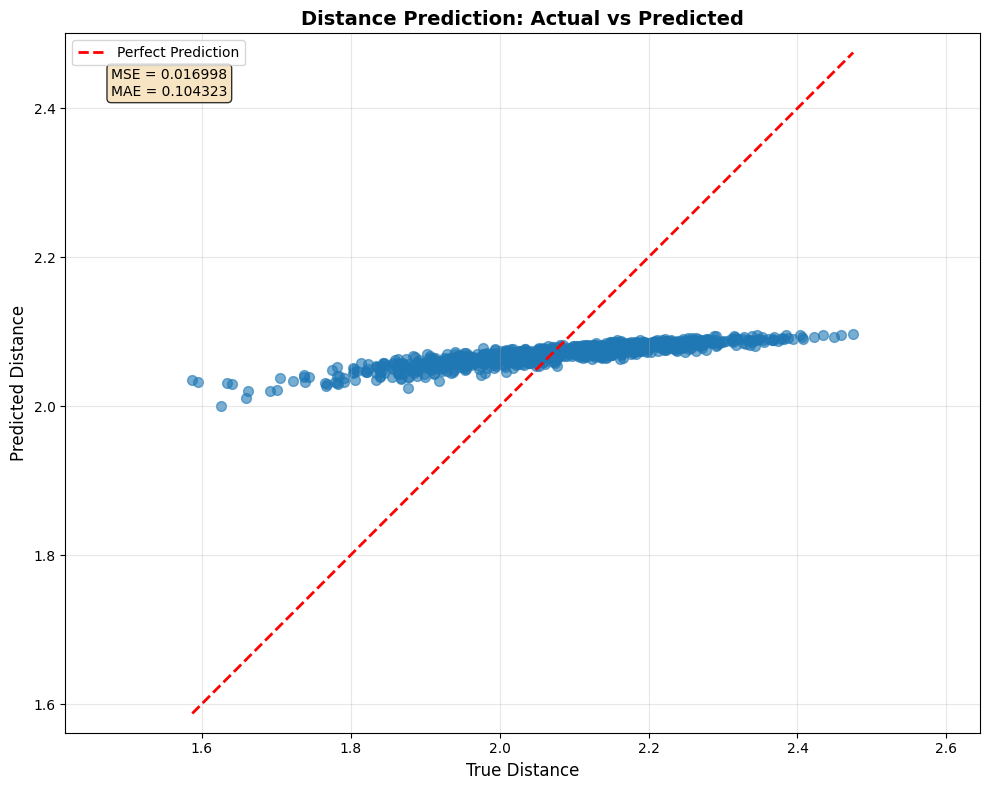

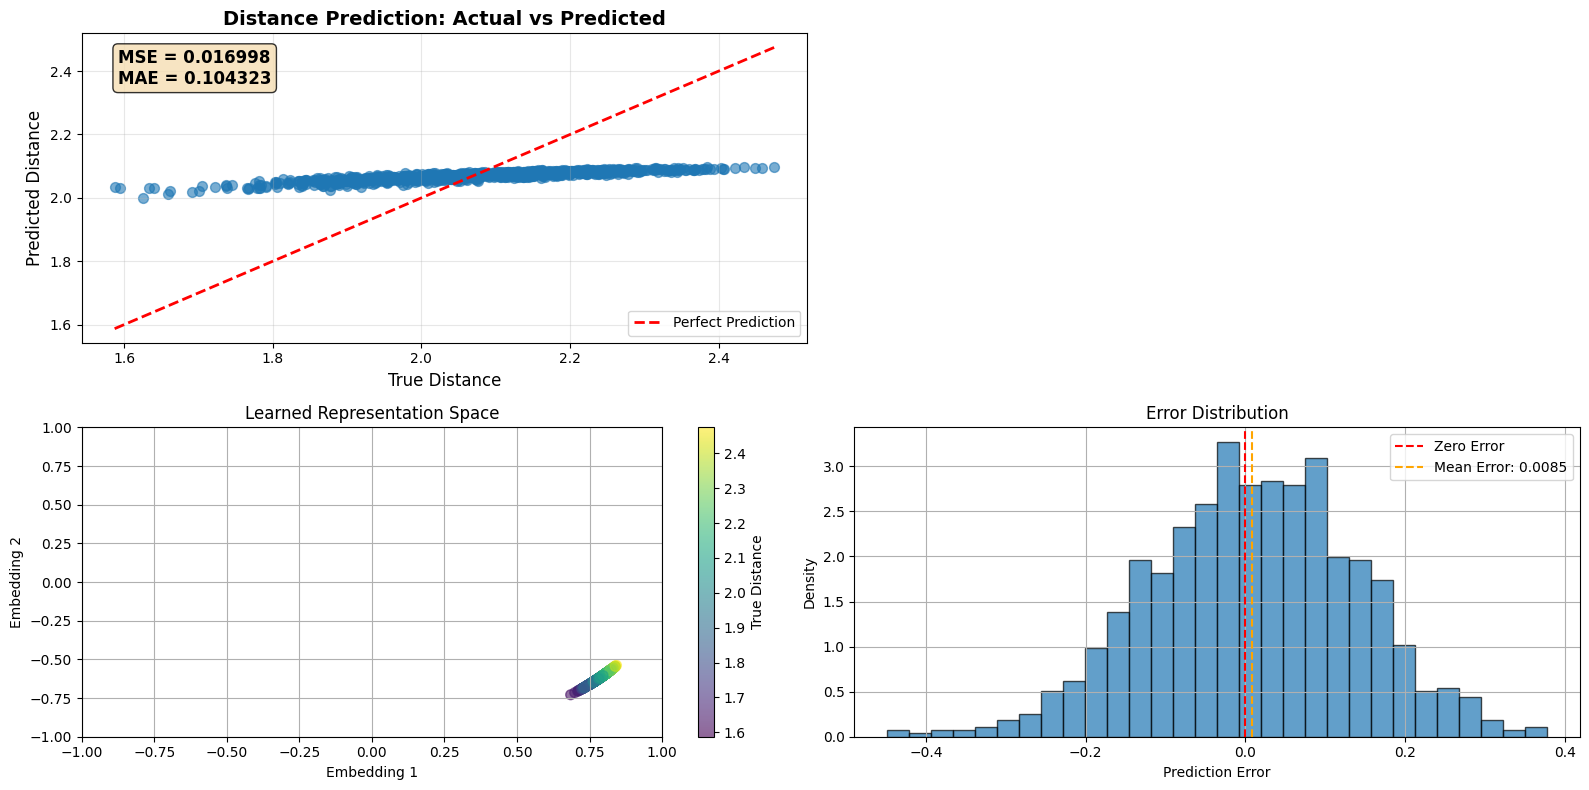

In [ ]:
def custom_loss_wrapper(y_true, y_pred):
    """
    Wrapper for PDC loss that handles the representation learning task.
    This should be used when applying PDC loss to representations.
    """
    # The PDC loss expects labels to be [batch_size, 1], but we're using it for 
    # representation learning where y_true are the input features [batch_size, 2]
    # We need to compute distances from the input features to use as labels
    
    # Compute distances from origin for each point in y_true (which are the input features)
    distances = tf.sqrt(tf.reduce_sum(tf.square(y_true), axis=1, keepdims=True))
    
    # Now apply PDC loss with proper shapes
    return mb.pdc_loss_vec(distances, y_pred, pm)

def distance_custom_loss(y_true, y_pred):
    """
    Custom loss for distance prediction task.
    y_true: true distances [batch_size, 1]
    y_pred: predicted distances [batch_size, 1]
    """
    # For distance prediction, we might want to use PDC loss as well
    # or just stick with MSE
    return tf.keras.losses.mse(y_true, y_pred)

noise_level = 0.15
trainer = TrainerV4_1(input_dim=16, hidden_dims=[8, 16, 32, 16, 8], embed_dim=2, use_normalize_layer=True)

# Option 1: Use PDC loss for representation learning (recommended)
( history,
    distance_metrics, 
    correlation, 
    distance_predictions, 
    representation_predictions, 
    X_train, 
    y_distance
    ) = trainer.train(
    representation_loss_fn=custom_loss_wrapper,  # PDC loss for representation learning
    distance_loss_weight=1.0,                    # Standard MSE for distance prediction
    representation_loss_weight=1.0,              # PDC loss for representation learning
    num_points=5000, 
    noise_level=noise_level, 
    epochs=300, 
    batch_size=1024,
    verbose=0
)

# Print results with new metrics
print(f"Final Pairwise Correlation: {correlation:.4f}")
print(f"Distance Prediction MAE: {distance_metrics['mae']:.6f}")

# Plot training history (now shows both losses)
trainer.plot_training_history(history)

# Plot the main actual vs predicted plot
trainer.plot_actual_vs_predicted(y_distance, distance_predictions)

# Plot comprehensive analysis including actual vs predicted
trainer.plot_predictions(X_train, y_distance, distance_predictions, representation_predictions)

# Generate test data and evaluate
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
test_predictions = trainer.model.predict(X_test)
test_distance_predictions = test_predictions[0]
test_representation_predictions = test_predictions[1]

# Evaluate on test data
test_distance_metrics = trainer.compute_distance_metrics(y_test, test_distance_predictions)
test_correlation = trainer.compute_pairwise_correlation(X_test, test_representation_predictions)

print(f"\nTest Set Performance:")
print(f"Test Pairwise Correlation: {test_correlation:.4f}")
print(f"Test Distance Prediction MAE: {test_distance_metrics['mae']:.6f}")

# Plot test results
trainer.plot_actual_vs_predicted(y_test, test_distance_predictions)
trainer.plot_predictions(X_test, y_test, test_distance_predictions, test_representation_predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step

Training Metrics:
Initial Total Loss: 6.639653
Final Total Loss: 0.188345
Initial Distance Loss: 5.626779
Final Distance Loss: 0.016234
Initial Representation Loss: 1.000004
Final Representation Loss: 0.172101
Convergence Threshold: 0.004648
Model did not converge to threshold
Total Training Time: 30.10 seconds
Average Time per Batch: 9.57 ms

Distance Prediction Metrics:
MSE: 0.016231
MAE: 0.102851

Representation Quality:
Pairwise Correlation: 0.0704
Noise Level Used: 0.15
Final Pairwise Correlation: 0.0704
Distance Prediction MAE: 0.102851


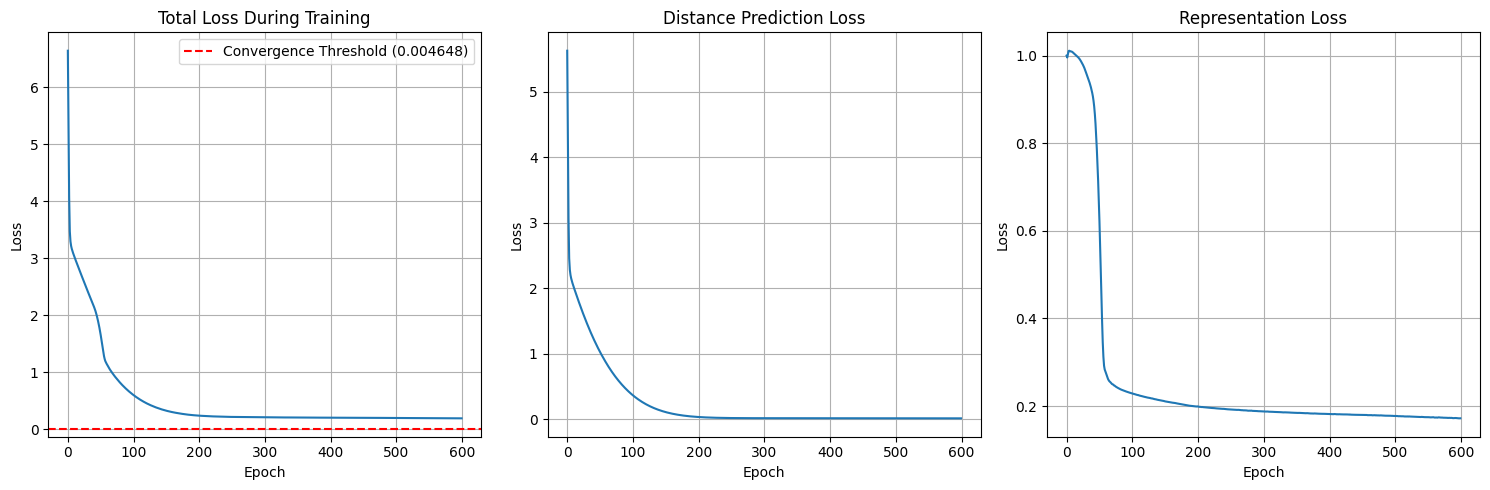

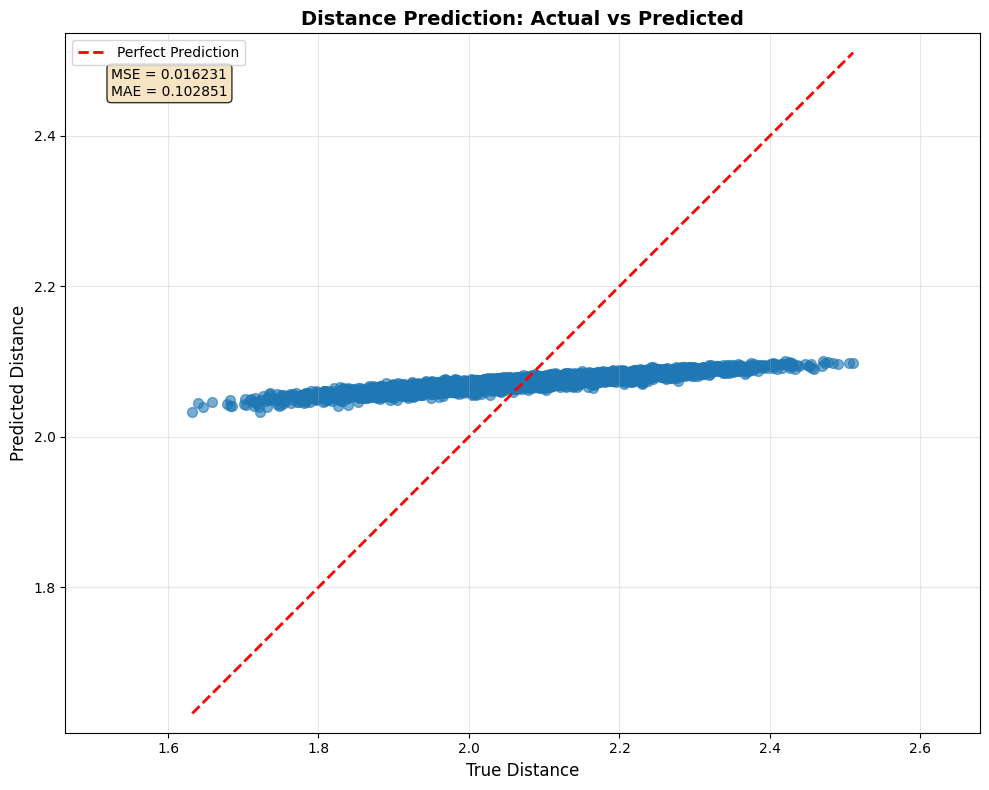

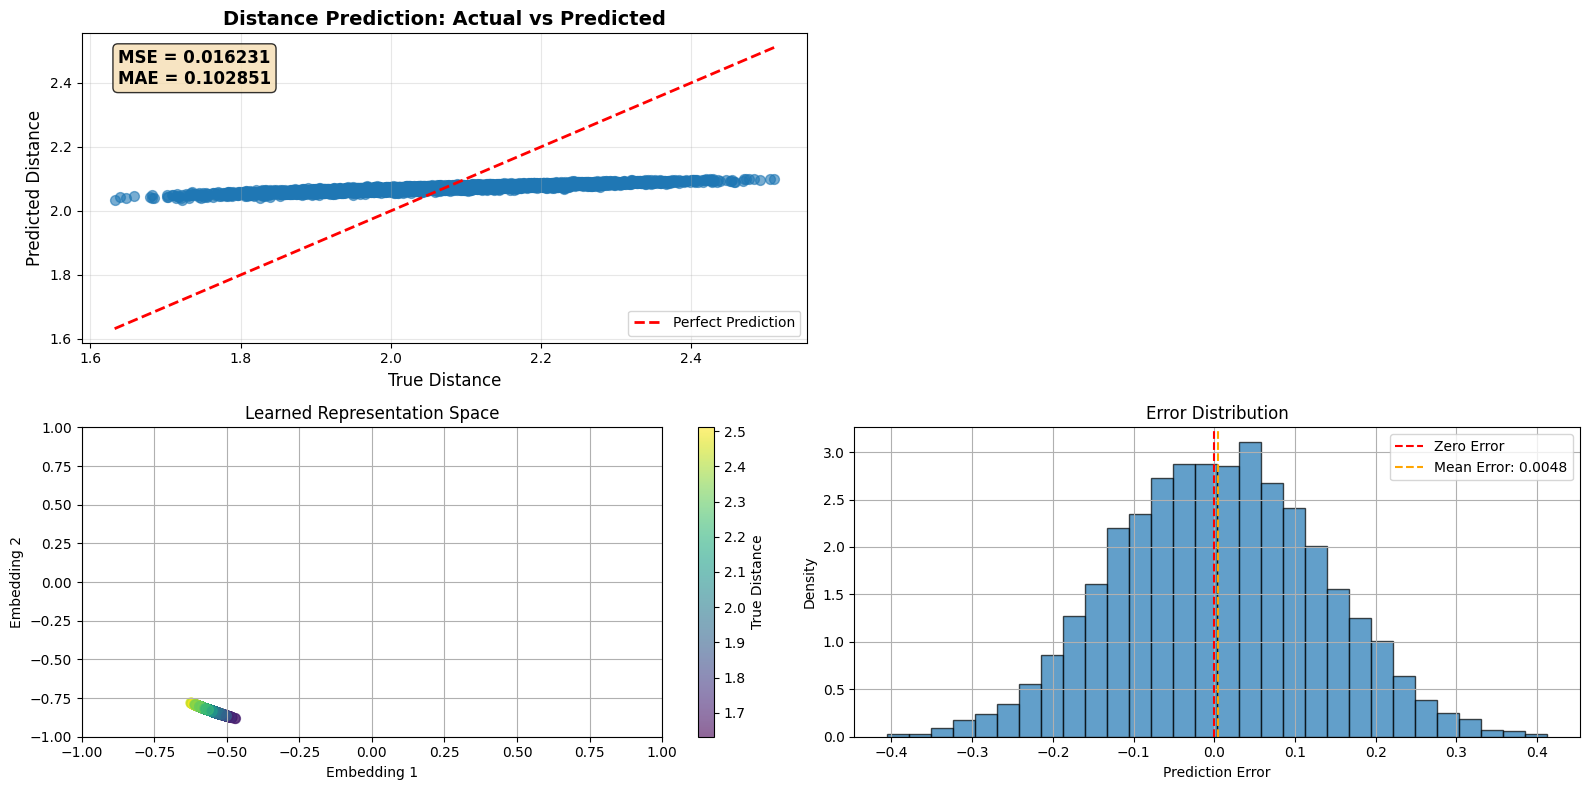

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step

Test Set Performance:
Test Pairwise Correlation: 0.0753
Test Distance Prediction MAE: 0.102276


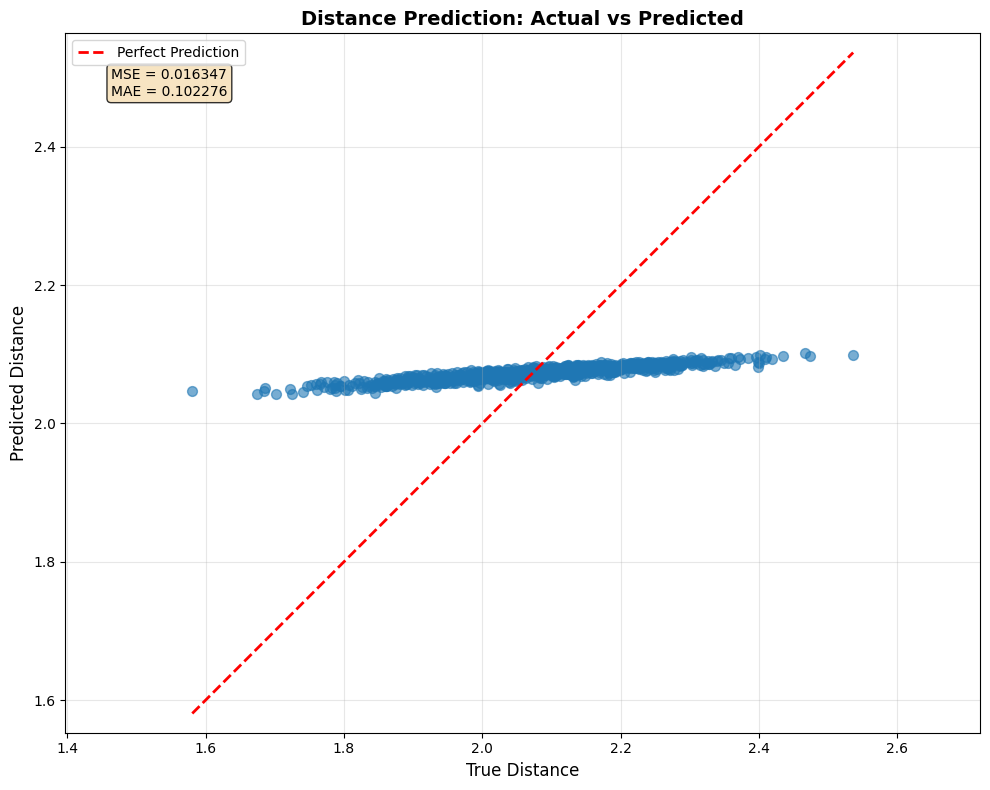

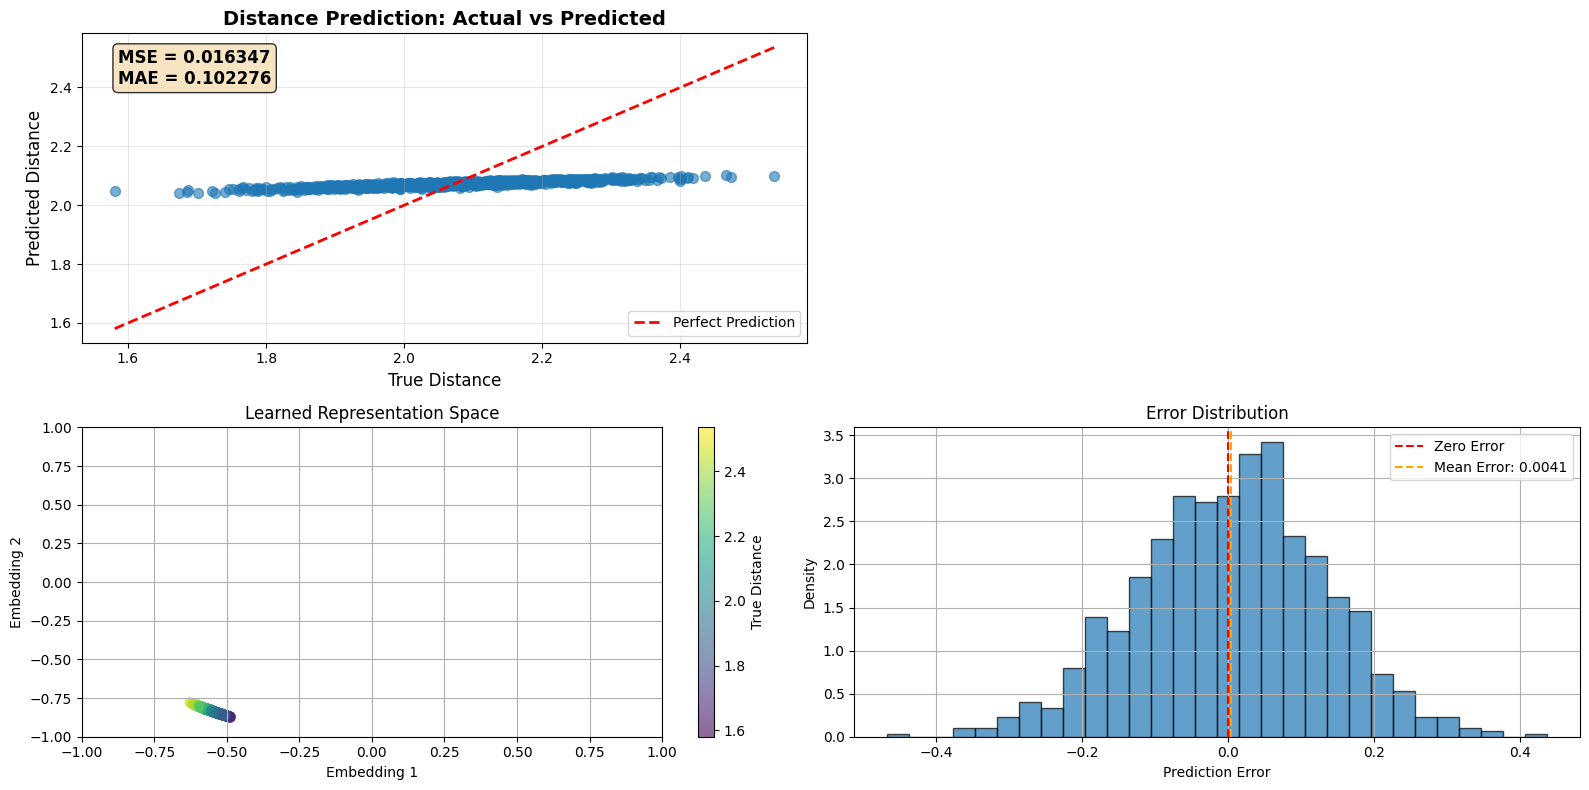

In [53]:
def custom_loss_wrapper(y_true, y_pred):
    """
    Wrapper for PDC loss that handles the representation learning task.
    This should be used when applying PDC loss to representations.
    """
    # The PDC loss expects labels to be [batch_size, 1], but we're using it for 
    # representation learning where y_true are the input features [batch_size, 2]
    # We need to compute distances from the input features to use as labels
    
    # Compute distances from origin for each point in y_true (which are the input features)
    distances = tf.sqrt(tf.reduce_sum(tf.square(y_true), axis=1, keepdims=True))
    
    # Now apply PDC loss with proper shapes
    return mb.pdc_loss_vec(distances, y_pred, pm)

def distance_custom_loss(y_true, y_pred):
    """
    Custom loss for distance prediction task.
    y_true: true distances [batch_size, 1]
    y_pred: predicted distances [batch_size, 1]
    """
    # For distance prediction, we might want to use PDC loss as well
    # or just stick with MSE
    return tf.keras.losses.mse(y_true, y_pred)

noise_level = 0.15
trainer = TrainerV4_1(input_dim=16, hidden_dims=[8, 16, 32, 16, 8], embed_dim=2, use_normalize_layer=True)

# Option 1: Use PDC loss for representation learning (recommended)
( history,
    distance_metrics, 
    correlation, 
    distance_predictions, 
    representation_predictions, 
    X_train, 
    y_distance
    ) = trainer.train(
    representation_loss_fn=custom_loss_wrapper,  # PDC loss for representation learning
    distance_loss_weight=1.0,                    # Standard MSE for distance prediction
    representation_loss_weight=1.0,              # PDC loss for representation learning
    num_points=5000, 
    noise_level=noise_level, 
    epochs=600, 
    batch_size=1024,
    verbose=0
)

# Print results with new metrics
print(f"Final Pairwise Correlation: {correlation:.4f}")
print(f"Distance Prediction MAE: {distance_metrics['mae']:.6f}")

# Plot training history (now shows both losses)
trainer.plot_training_history(history)

# Plot the main actual vs predicted plot
trainer.plot_actual_vs_predicted(y_distance, distance_predictions)

# Plot comprehensive analysis including actual vs predicted
trainer.plot_predictions(X_train, y_distance, distance_predictions, representation_predictions)

# Generate test data and evaluate
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
test_predictions = trainer.model.predict(X_test)
test_distance_predictions = test_predictions[0]
test_representation_predictions = test_predictions[1]

# Evaluate on test data
test_distance_metrics = trainer.compute_distance_metrics(y_test, test_distance_predictions)
test_correlation = trainer.compute_pairwise_correlation(X_test, test_representation_predictions)

print(f"\nTest Set Performance:")
print(f"Test Pairwise Correlation: {test_correlation:.4f}")
print(f"Test Distance Prediction MAE: {test_distance_metrics['mae']:.6f}")

# Plot test results
trainer.plot_actual_vs_predicted(y_test, test_distance_predictions)
trainer.plot_predictions(X_test, y_test, test_distance_predictions, test_representation_predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step

Training Metrics:
Initial Total Loss: 5.215745
Final Total Loss: 0.184981
Initial Distance Loss: 4.213634
Final Distance Loss: 0.003018
Initial Representation Loss: 0.997199
Final Representation Loss: 0.181742
Convergence Threshold: 0.003651
Model did not converge to threshold
Total Training Time: 14.99 seconds
Average Time per Batch: 9.16 ms

Distance Prediction Metrics:
MSE: 0.003018
MAE: 0.043990

Representation Quality:
Pairwise Correlation: 0.0570
Noise Level Used: 0.15
Final Pairwise Correlation: 0.0570
Distance Prediction MAE: 0.043990


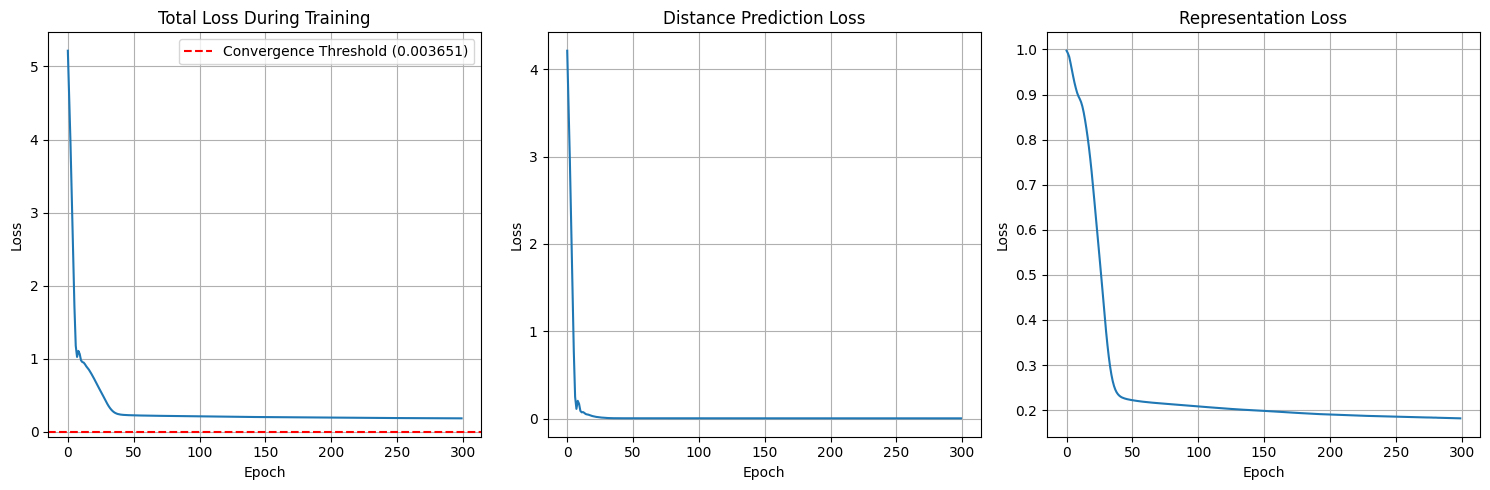

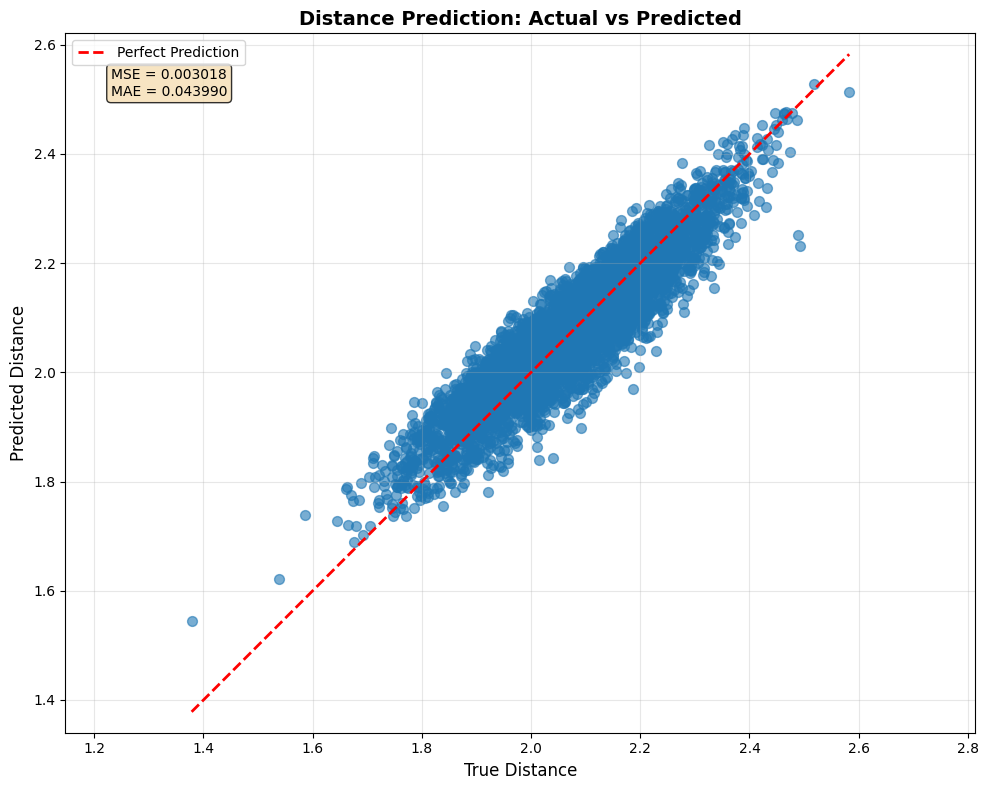

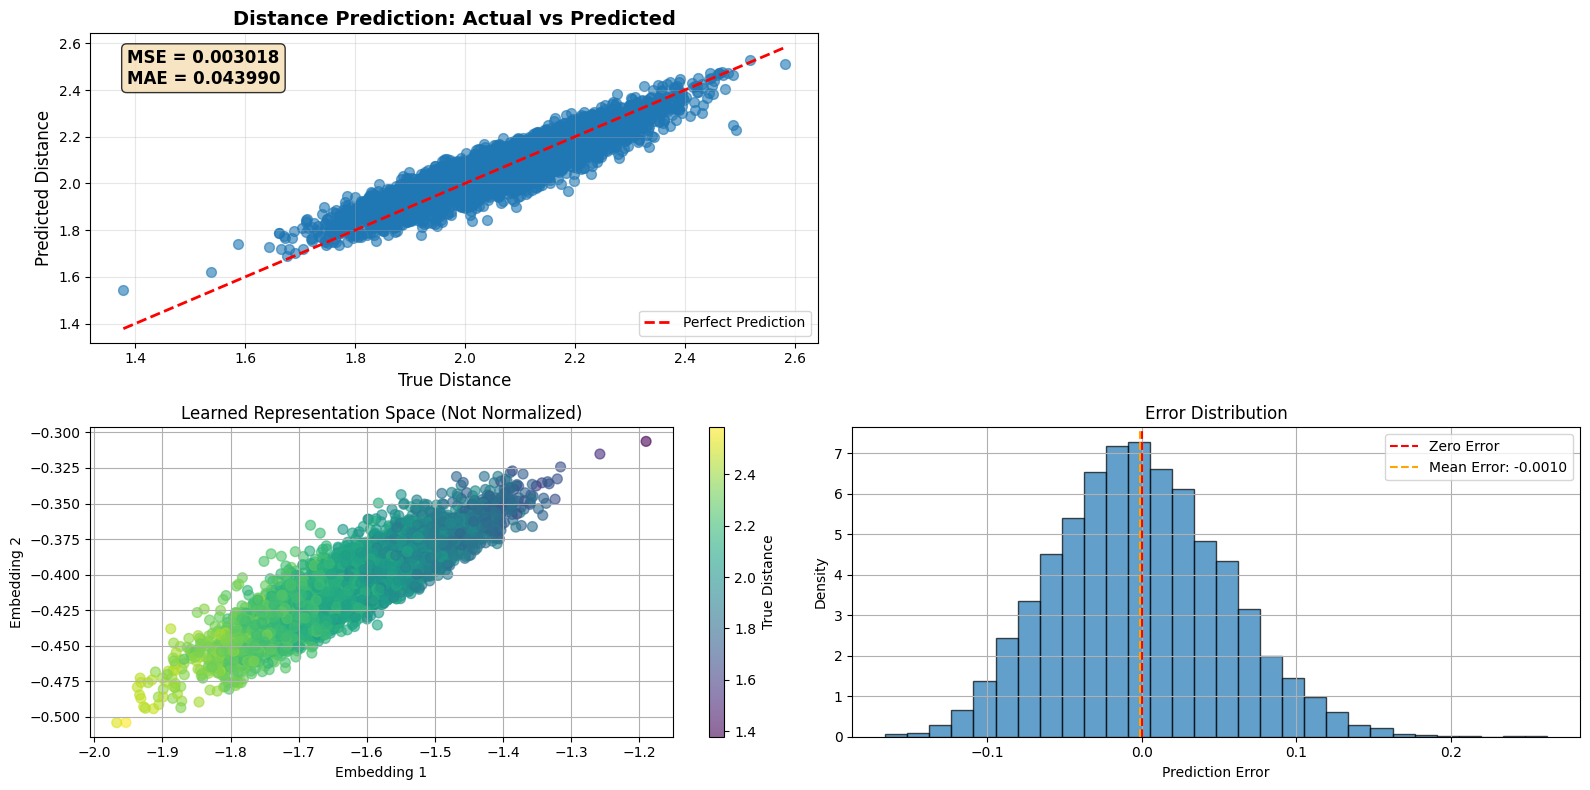

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step

Test Set Performance:
Test Pairwise Correlation: 0.0750
Test Distance Prediction MAE: 0.044255


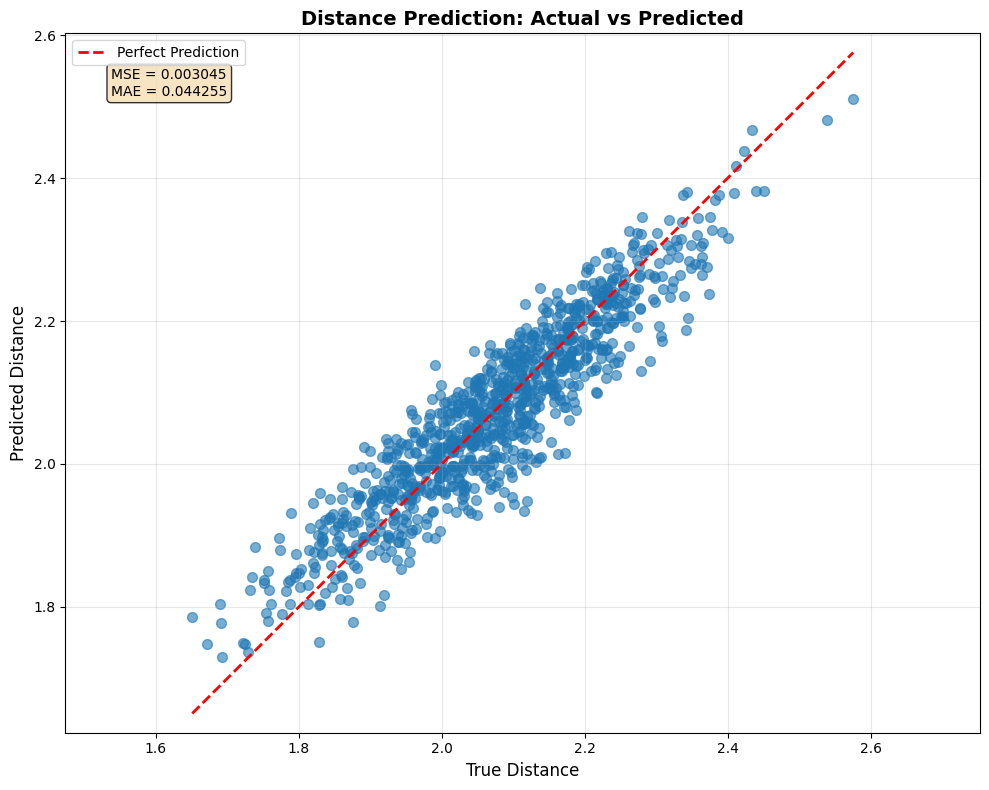

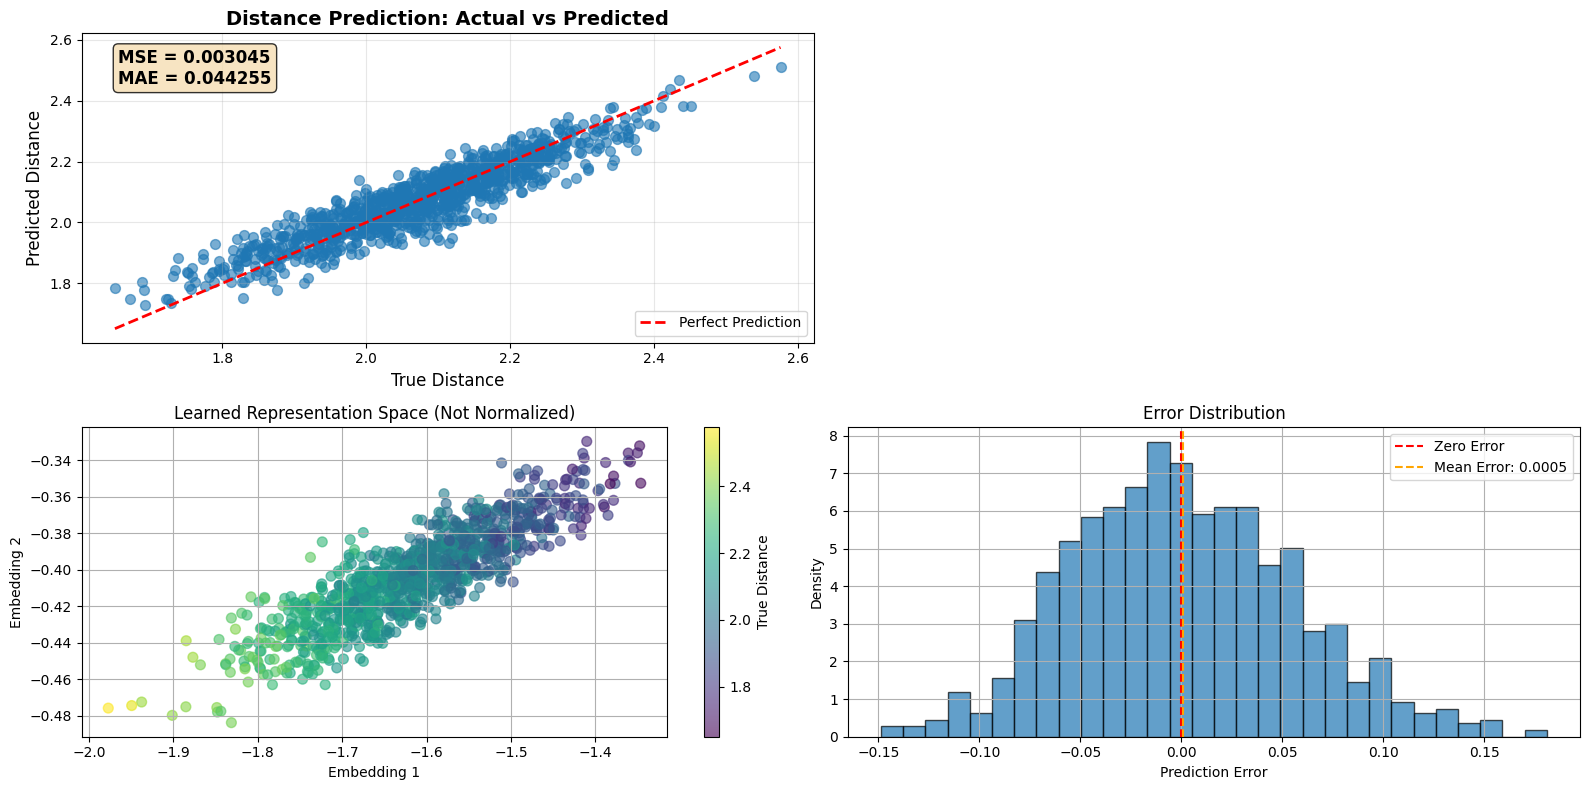

In [54]:
def custom_loss_wrapper(y_true, y_pred):
    """
    Wrapper for PDC loss that handles the representation learning task.
    This should be used when applying PDC loss to representations.
    """
    # The PDC loss expects labels to be [batch_size, 1], but we're using it for 
    # representation learning where y_true are the input features [batch_size, 2]
    # We need to compute distances from the input features to use as labels
    
    # Compute distances from origin for each point in y_true (which are the input features)
    distances = tf.sqrt(tf.reduce_sum(tf.square(y_true), axis=1, keepdims=True))
    
    # Now apply PDC loss with proper shapes
    return mb.pdc_loss_vec(distances, y_pred, pm)

def distance_custom_loss(y_true, y_pred):
    """
    Custom loss for distance prediction task.
    y_true: true distances [batch_size, 1]
    y_pred: predicted distances [batch_size, 1]
    """
    # For distance prediction, we might want to use PDC loss as well
    # or just stick with MSE
    return tf.keras.losses.mse(y_true, y_pred)

noise_level = 0.15
trainer = TrainerV4_1(input_dim=16, hidden_dims=[8, 16, 32, 16, 8], embed_dim=2, use_normalize_layer=False)

# Option 1: Use PDC loss for representation learning (recommended)
( history,
    distance_metrics, 
    correlation, 
    distance_predictions, 
    representation_predictions, 
    X_train, 
    y_distance
    ) = trainer.train(
    representation_loss_fn=custom_loss_wrapper,  # PDC loss for representation learning
    distance_loss_weight=1.0,                    # Standard MSE for distance prediction
    representation_loss_weight=1.0,              # PDC loss for representation learning
    num_points=5000, 
    noise_level=noise_level, 
    epochs=300, 
    batch_size=1024,
    verbose=0
)

# Print results with new metrics
print(f"Final Pairwise Correlation: {correlation:.4f}")
print(f"Distance Prediction MAE: {distance_metrics['mae']:.6f}")

# Plot training history (now shows both losses)
trainer.plot_training_history(history)

# Plot the main actual vs predicted plot
trainer.plot_actual_vs_predicted(y_distance, distance_predictions)

# Plot comprehensive analysis including actual vs predicted
trainer.plot_predictions(X_train, y_distance, distance_predictions, representation_predictions)

# Generate test data and evaluate
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
test_predictions = trainer.model.predict(X_test)
test_distance_predictions = test_predictions[0]
test_representation_predictions = test_predictions[1]

# Evaluate on test data
test_distance_metrics = trainer.compute_distance_metrics(y_test, test_distance_predictions)
test_correlation = trainer.compute_pairwise_correlation(X_test, test_representation_predictions)

print(f"\nTest Set Performance:")
print(f"Test Pairwise Correlation: {test_correlation:.4f}")
print(f"Test Distance Prediction MAE: {test_distance_metrics['mae']:.6f}")

# Plot test results
trainer.plot_actual_vs_predicted(y_test, test_distance_predictions)
trainer.plot_predictions(X_test, y_test, test_distance_predictions, test_representation_predictions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step

Training Metrics:
Initial Total Loss: 9.344448
Final Total Loss: 0.165158
Initial Distance Loss: 8.312140
Final Distance Loss: 0.002596
Initial Representation Loss: 1.001724
Final Representation Loss: 0.162742
Convergence Threshold: 0.006541
Model did not converge to threshold
Total Training Time: 57.07 seconds
Average Time per Batch: 9.25 ms

Distance Prediction Metrics:
MSE: 0.002606
MAE: 0.040649

Representation Quality:
Pairwise Correlation: 0.0667
Noise Level Used: 0.15
Final Pairwise Correlation: 0.0667
Distance Prediction MAE: 0.040649


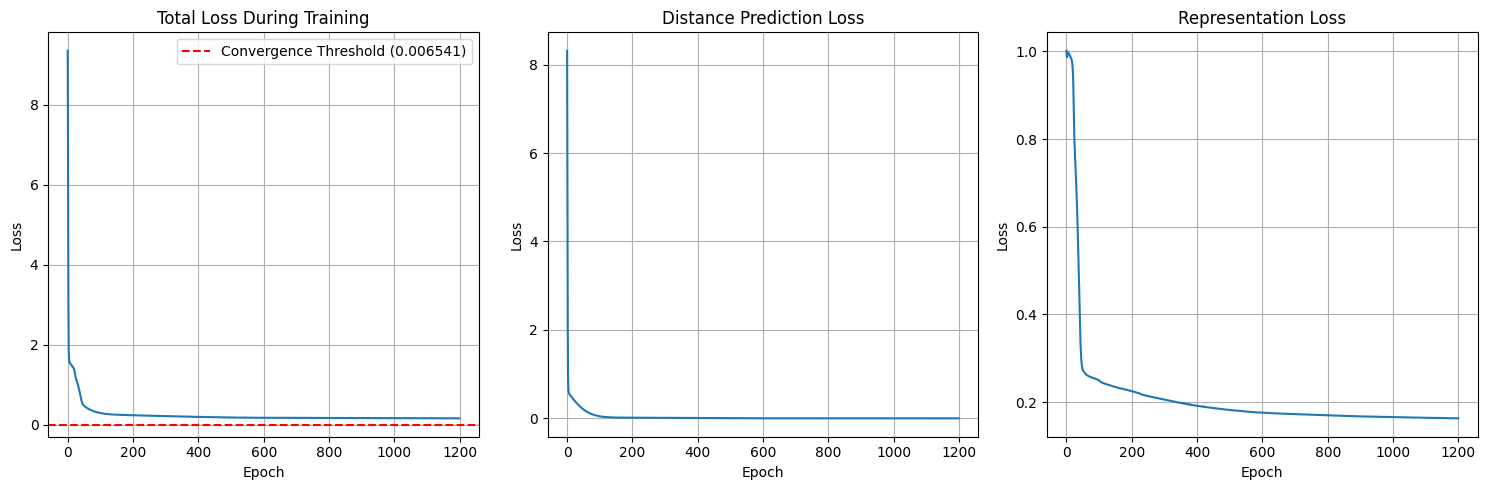

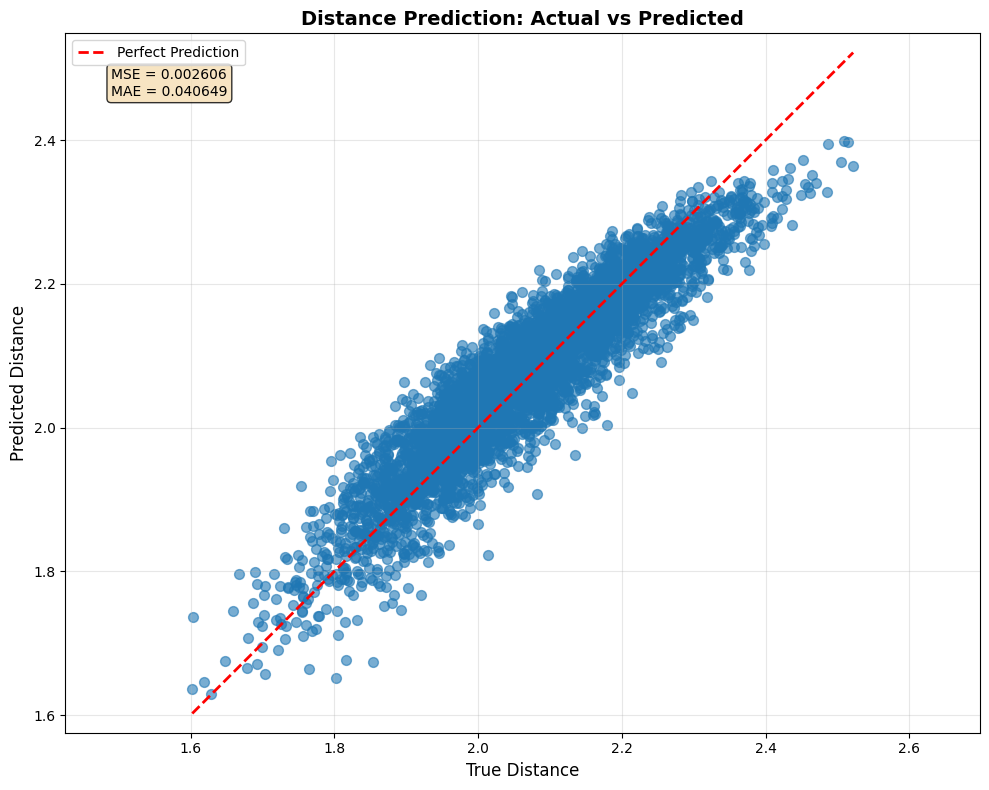

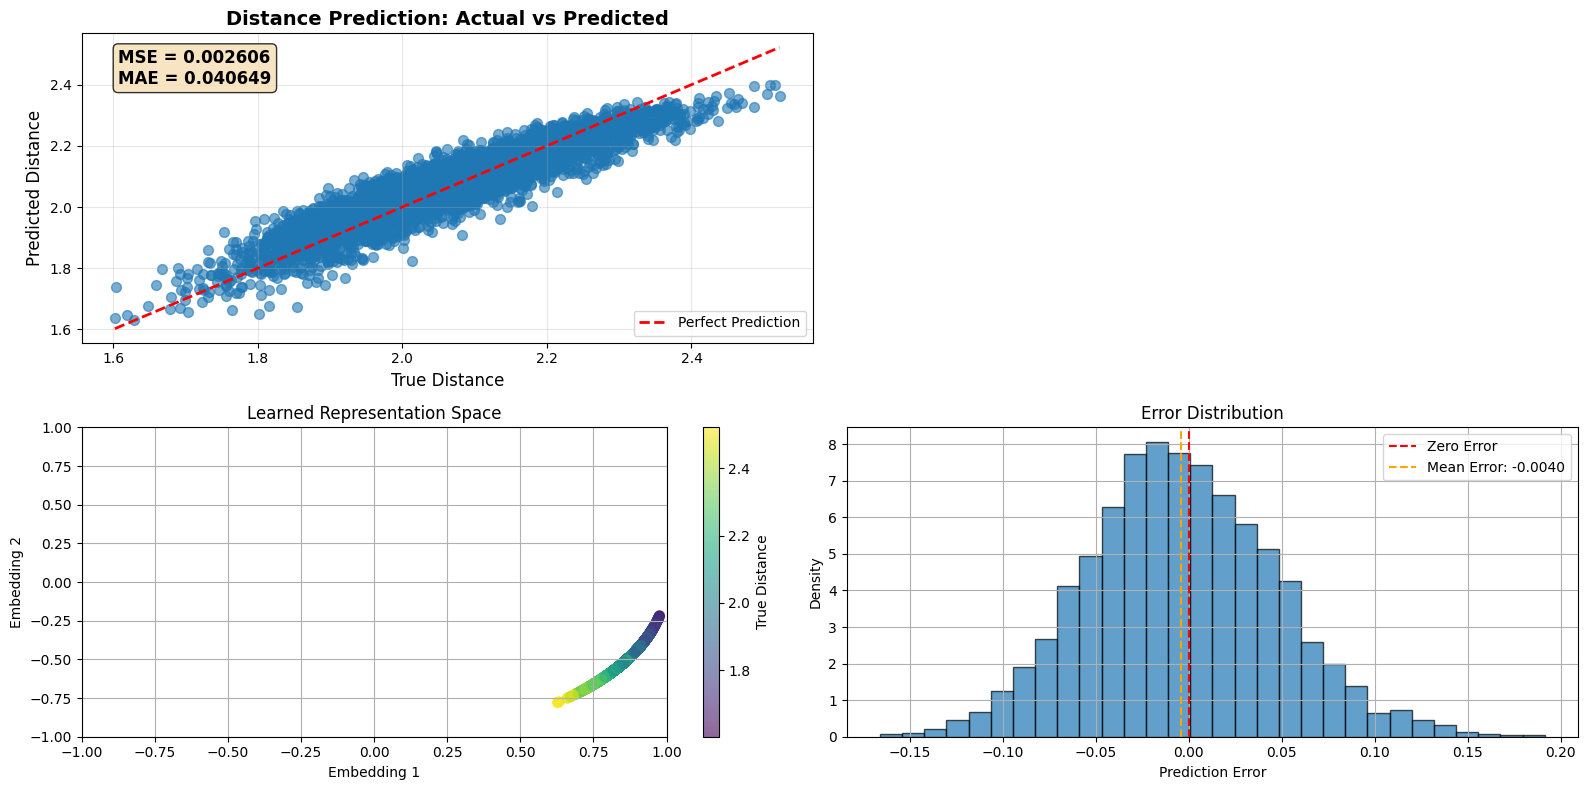

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step

Test Set Performance:
Test Pairwise Correlation: 0.0553
Test Distance Prediction MAE: 0.045286


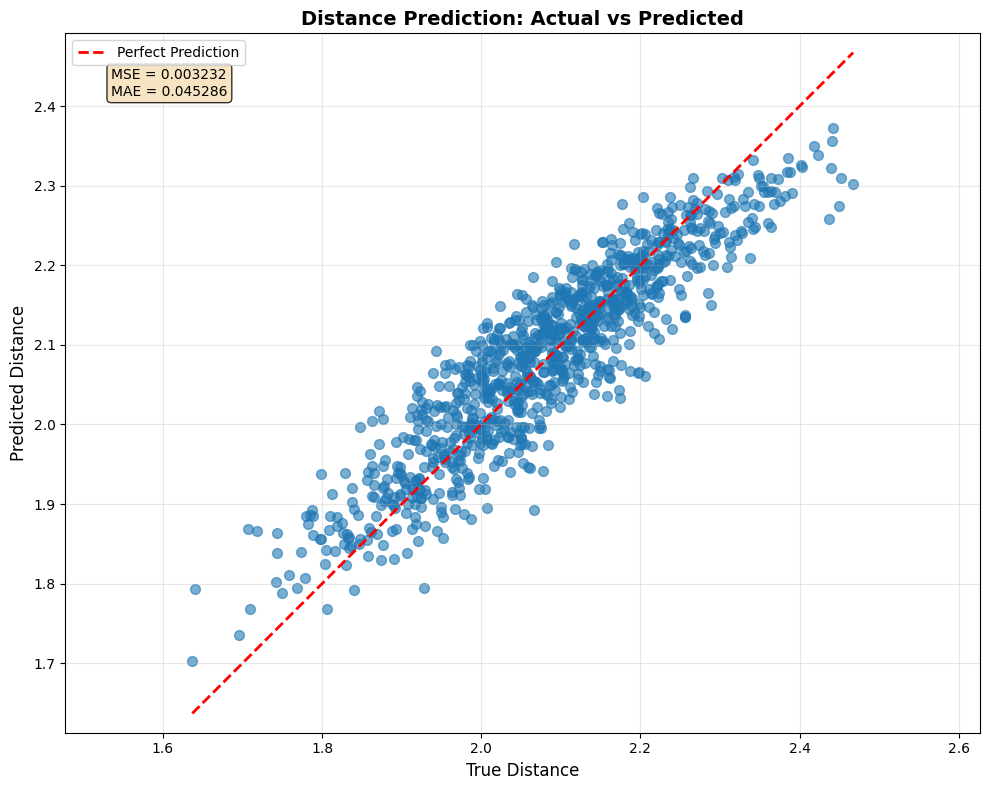

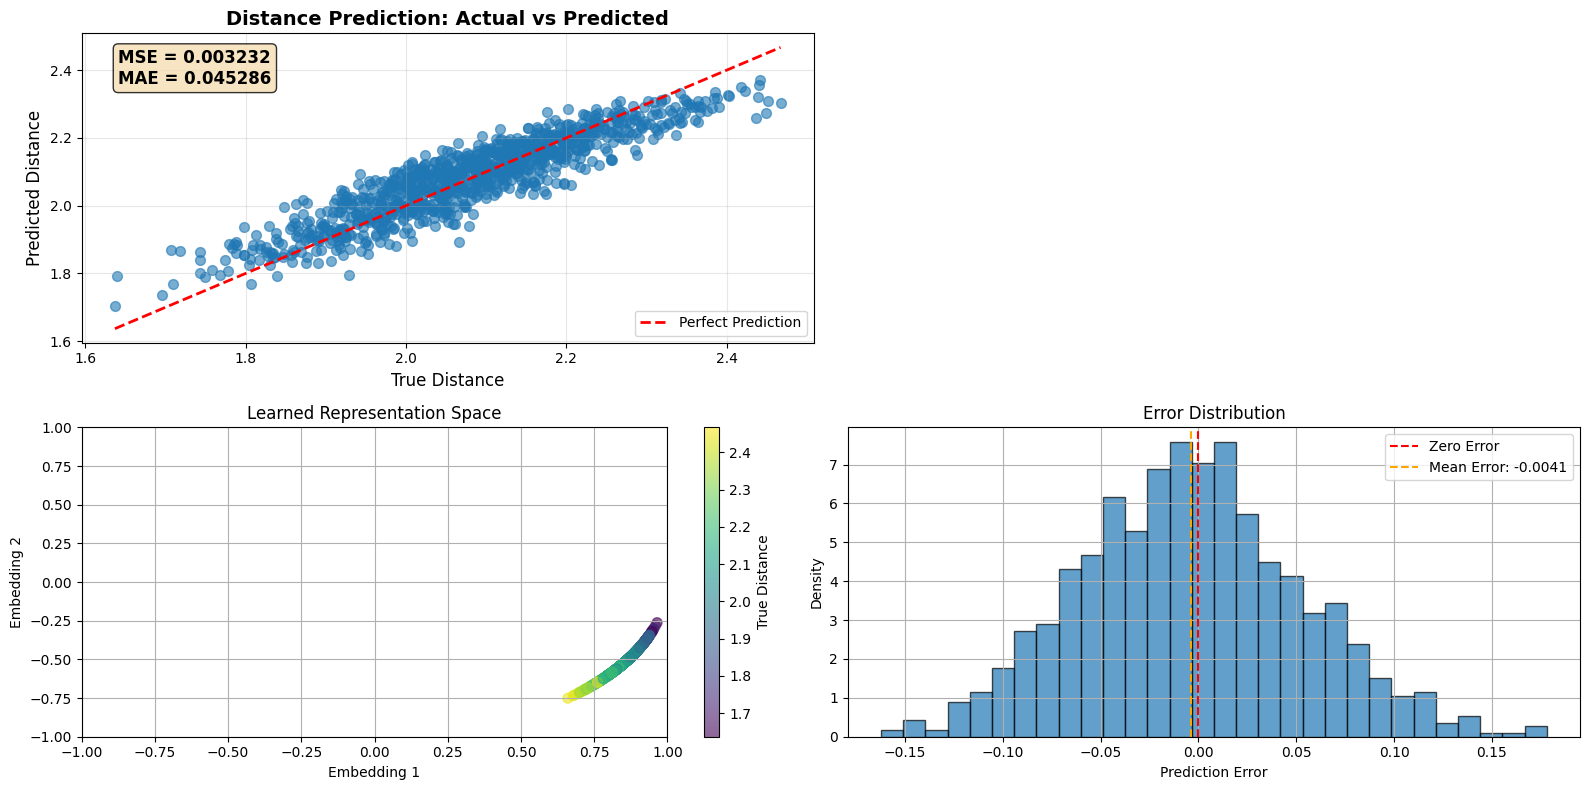

In [59]:
def custom_loss_wrapper(y_true, y_pred):
    """
    Wrapper for PDC loss that handles the representation learning task.
    This should be used when applying PDC loss to representations.
    """
    # The PDC loss expects labels to be [batch_size, 1], but we're using it for 
    # representation learning where y_true are the input features [batch_size, 2]
    # We need to compute distances from the input features to use as labels
    
    # Compute distances from origin for each point in y_true (which are the input features)
    distances = tf.sqrt(tf.reduce_sum(tf.square(y_true), axis=1, keepdims=True))
    
    # Now apply PDC loss with proper shapes
    return mb.pdc_loss_vec(distances, y_pred, pm)

def distance_custom_loss(y_true, y_pred):
    """
    Custom loss for distance prediction task.
    y_true: true distances [batch_size, 1]
    y_pred: predicted distances [batch_size, 1]
    """
    # For distance prediction, we might want to use PDC loss as well
    # or just stick with MSE
    return tf.keras.losses.mse(y_true, y_pred)

noise_level = 0.15
trainer = TrainerV4_1(input_dim=16, hidden_dims=[8, 16, 32, 16, 8], embed_dim=2, use_normalize_layer=True)

# Option 1: Use PDC loss for representation learning (recommended)
( history,
    distance_metrics, 
    correlation, 
    distance_predictions, 
    representation_predictions, 
    X_train, 
    y_distance
    ) = trainer.train(
    representation_loss_fn=custom_loss_wrapper,  # PDC loss for representation learning
    distance_loss_weight=1.0,                    # Standard MSE for distance prediction
    representation_loss_weight=1.0,              # PDC loss for representation learning
    num_points=5000, 
    noise_level=noise_level, 
    epochs=1200, 
    batch_size=1024,
    verbose=0
)

# Print results with new metrics
print(f"Final Pairwise Correlation: {correlation:.4f}")
print(f"Distance Prediction MAE: {distance_metrics['mae']:.6f}")

# Plot training history (now shows both losses)
trainer.plot_training_history(history)

# Plot the main actual vs predicted plot
trainer.plot_actual_vs_predicted(y_distance, distance_predictions)

# Plot comprehensive analysis including actual vs predicted
trainer.plot_predictions(X_train, y_distance, distance_predictions, representation_predictions)

# Generate test data and evaluate
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=noise_level)
test_predictions = trainer.model.predict(X_test)
test_distance_predictions = test_predictions[0]
test_representation_predictions = test_predictions[1]

# Evaluate on test data
test_distance_metrics = trainer.compute_distance_metrics(y_test, test_distance_predictions)
test_correlation = trainer.compute_pairwise_correlation(X_test, test_representation_predictions)

print(f"\nTest Set Performance:")
print(f"Test Pairwise Correlation: {test_correlation:.4f}")
print(f"Test Distance Prediction MAE: {test_distance_metrics['mae']:.6f}")

# Plot test results
trainer.plot_actual_vs_predicted(y_test, test_distance_predictions)
trainer.plot_predictions(X_test, y_test, test_distance_predictions, test_representation_predictions)

In [8]:
class TrainerV4_2:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2, embed_dim=2, use_normalize_layer=True, use_Lspread=False, K=1.8):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.embed_dim = embed_dim
        self.use_normalize_layer = use_normalize_layer
        self.use_Lspread = use_Lspread
        self.K = K # coefficient for L_spread loss
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()
        self.convergence_threshold = None

        # For tracking global min/max samples
        self.global_min_idx = None
        self.global_max_idx = None
        self.global_y_min = None
        self.global_y_max = None
        self.X_min_sample = None  # Store the actual feature vectors
        self.X_max_sample = None

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)

        # Representation output (optionally normalized vector)
        representation_output = Dense(self.embed_dim, name='representation_raw')(x)
        if self.use_normalize_layer:
            representation_output = NormalizeLayer(name='normalize_layer')(representation_output)
            rep_output_name = 'normalize_layer'
        else:
            rep_output_name = 'representation_raw'

        # Distance prediction from representation
        distance_output = Dense(1, name='distance_prediction')(representation_output)

        model = Model(inputs=inputs, outputs=[distance_output, representation_output])
        self.rep_output_name = rep_output_name
        return model

    def generate_synthetic_data(self, num_points=200, noise_level=0.15):
        """Generate synthetic data and store global min/max samples."""
        # Generate more points than needed for sampling
        pool_size = num_points * 10
        features = np.random.uniform(0, 1, (pool_size, self.input_dim))

        # Calculate distances from origin for N-dimensional space
        distances = np.sqrt(np.sum(features ** 2, axis=1))

        # Create weights favoring middle distances
        max_distance = np.sqrt(self.input_dim)
        gaussian_center = max_distance * 0.5

        weights = np.exp(-((distances - gaussian_center) ** 2) / (2 * noise_level ** 2))
        weights = weights / np.sum(weights)

        # Sample indices according to weights
        selected_indices = np.random.choice(
            pool_size,
            size=num_points,
            p=weights,
            replace=False
        )

        # Select the points
        selected_features = features[selected_indices]
        selected_distances = distances[selected_indices]

        # Find global min and max in the selected data
        self.global_min_idx = np.argmin(selected_distances)
        self.global_max_idx = np.argmax(selected_distances)
        self.global_y_min = selected_distances[self.global_min_idx]
        self.global_y_max = selected_distances[self.global_max_idx]

        # Store the actual feature vectors for global min/max samples
        self.X_min_sample = selected_features[self.global_min_idx:self.global_min_idx+1]  # Keep as (1, input_dim)
        self.X_max_sample = selected_features[self.global_max_idx:self.global_max_idx+1]  # Keep as (1, input_dim)

        print(f"Global min: idx={self.global_min_idx}, value={self.global_y_min:.6f}")
        print(f"Global max: idx={self.global_max_idx}, value={self.global_y_max:.6f}")

        return selected_features, selected_distances.reshape(-1, 1)

    def create_spread_loss_function(self):
        """
        Create L_spread loss function that computes: L_spread = (K - dist(z_min, z_max))^2

        This function:
        1. Creates a functional model to extract representations
        2. Gets current embeddings for global min/max samples
        3. Computes the Euclidean distance between them
        4. Returns the squared difference from target distance K
        """
        # Create a functional model to extract representations
        representation_model = Model(
            inputs=self.model.input,
            outputs=self.model.get_layer(self.rep_output_name).output
        )

        # Convert min/max samples to tensors for TensorFlow operations
        X_min_tensor = tf.constant(self.X_min_sample, dtype=tf.float32)
        X_max_tensor = tf.constant(self.X_max_sample, dtype=tf.float32)

        def spread_loss_fn(y_true, y_pred):
            """
            L_spread loss function.

            Args:
                y_true: Ground truth (not used in spread loss computation)
                y_pred: Model predictions (not used in spread loss computation)

            Returns:
                L_spread = (K - dist(z_min, z_max))^2
            """
            # Get current embeddings for global min/max samples
            z_min = representation_model(X_min_tensor)[0]  # Get first (and only) sample
            z_max = representation_model(X_max_tensor)[0]  # Get first (and only) sample

            # Compute Euclidean distance between embeddings
            embedding_distance = tf.norm(z_min - z_max)

            # L_spread = (K - dist(z_min, z_max))^2
            spread_loss = tf.square(self.K - embedding_distance)

            return spread_loss

        return spread_loss_fn

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions."""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def compute_distance_metrics(self, y_true, y_pred):
        """Compute evaluation metrics for distance prediction."""
        mse = tf.keras.losses.mse(y_true, y_pred).numpy().mean()
        mae = tf.keras.losses.mae(y_true, y_pred).numpy().mean()
        return {
            'mse': mse,
            'mae': mae,
        }

    def train(
        self,
        representation_loss_fn=None,
        distance_loss_weight=1.0,
        representation_loss_weight=0.5,
        spread_loss_weight=0.1,
        representation_targets=None,
        num_points=2000,
        epochs=1000,
        batch_size=32,
        noise_level=0.15,
        verbose=0):
        """Train the model with optional L_spread term computed at every iteration."""

        # Generate synthetic data and identify global min/max
        X_train, y_distance = self.generate_synthetic_data(num_points=num_points, noise_level=noise_level)

        # Set representation targets
        if representation_targets is None:
            y_representation = X_train
        else:
            y_representation = representation_targets

        # Set representation loss function
        if representation_loss_fn is None:
            representation_loss_fn = 'mse'

        # Standard losses and targets
        loss_dict = {
            'distance_prediction': 'mse',
            self.rep_output_name: representation_loss_fn
        }
        loss_weights_dict = {
            'distance_prediction': distance_loss_weight,
            self.rep_output_name: representation_loss_weight
        }
        metrics_dict = {
            'distance_prediction': ['mae'],
            self.rep_output_name: []
        }
        targets = {
            'distance_prediction': y_distance,
            self.rep_output_name: y_representation
        }

        # Add spread loss if enabled
        if self.use_Lspread:
            # Create the spread loss function
            spread_loss_fn = self.create_spread_loss_function()

            # Store original representation loss
            original_rep_loss = representation_loss_fn

            def combined_rep_loss(y_true, y_pred):
                """Combine original representation loss with spread loss."""
                # Original representation loss
                if callable(original_rep_loss):
                    orig_loss = original_rep_loss(y_true, y_pred)
                else:
                    if original_rep_loss == 'mse':
                        orig_loss = tf.reduce_mean(tf.keras.losses.mse(y_true, y_pred))
                    else:
                        orig_loss = tf.constant(0.0, dtype=tf.float32)

                # Spread loss (computed using current global min/max embeddings)
                spread_loss = spread_loss_fn(y_true, y_pred)

                # Combine losses
                total_loss = orig_loss + spread_loss_weight * spread_loss

                return total_loss

            # Update the loss function for representations
            loss_dict[self.rep_output_name] = combined_rep_loss

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=loss_dict,
            loss_weights=loss_weights_dict,
            metrics=metrics_dict
        )

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, targets))
        train_dataset = train_dataset.batch(batch_size)

        # Training setup with spread loss tracking
        start_time = time.time()
        batch_times = []
        convergence_epoch = None
        convergence_time = None
        spread_losses = []  # Track spread loss over time

        class SpreadLossTracker(tf.keras.callbacks.Callback):
            def __init__(self, trainer):
                super().__init__()
                self.trainer = trainer
                self.representation_model = None

            def on_train_begin(self, logs=None):
                if self.trainer.use_Lspread:
                    # Create representation model for tracking
                    self.representation_model = Model(
                        inputs=self.trainer.model.input,
                        outputs=self.trainer.model.get_layer(self.trainer.rep_output_name).output
                    )

            def on_epoch_end(self, epoch, logs=None):
                if self.trainer.use_Lspread and self.representation_model is not None:
                    # Compute current spread loss
                    z_min = self.representation_model(self.trainer.X_min_sample)[0]
                    z_max = self.representation_model(self.trainer.X_max_sample)[0]
                    current_distance = np.linalg.norm(z_min.numpy() - z_max.numpy())
                    current_spread_loss = (self.trainer.K - current_distance) ** 2
                    spread_losses.append(current_spread_loss)

                    if epoch % 50 == 0 or epoch < 10:  # Print periodically
                        print(f"Epoch {epoch}: Embedding distance = {current_distance:.6f}, "
                              f"Spread loss = {current_spread_loss:.6f}, Target K = {self.trainer.K}")

        class ConvergenceCallback(tf.keras.callbacks.Callback):
            def __init__(self, trainer, threshold_factor=0.0007):
                super().__init__()
                self.trainer = trainer
                self.threshold_factor = threshold_factor
                self.first_loss = None
                self.convergence_reached = False
                self.batch_start_time = None

            def on_train_begin(self, logs=None):
                self.batch_start_time = time.time()

            def on_batch_end(self, batch, logs=None):
                batch_end_time = time.time()
                batch_duration = batch_end_time - self.batch_start_time
                batch_times.append(batch_duration)
                self.batch_start_time = batch_end_time

            def on_epoch_end(self, epoch, logs=None):
                current_loss = logs['loss']
                if self.first_loss is None:
                    self.first_loss = current_loss
                    self.trainer.convergence_threshold = self.first_loss * self.threshold_factor

                if not self.convergence_reached and current_loss <= self.trainer.convergence_threshold:
                    self.convergence_reached = True
                    nonlocal convergence_epoch, convergence_time
                    convergence_epoch = epoch + 1
                    convergence_time = time.time() - start_time

        # Create callbacks
        convergence_callback = ConvergenceCallback(self)
        spread_tracker = SpreadLossTracker(self)

        # Training
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[
                IsTraining(self.phase_manager),
                convergence_callback,
                spread_tracker
            ]
        )

        # Final predictions and evaluation
        predictions = self.model.predict(X_train)
        distance_predictions = predictions[0]
        representation_predictions = predictions[1]

        distance_metrics = self.compute_distance_metrics(y_distance, distance_predictions)
        correlation = self.compute_pairwise_correlation(X_train, representation_predictions)

        # Print results
        total_time = time.time() - start_time
        avg_batch_time = np.mean(batch_times)

        print("\nTraining Metrics:")
        print(f"Initial Total Loss: {history.history['loss'][0]:.6f}")
        print(f"Final Total Loss: {history.history['loss'][-1]:.6f}")
        print(f"Initial Distance Loss: {history.history['distance_prediction_loss'][0]:.6f}")
        print(f"Final Distance Loss: {history.history['distance_prediction_loss'][-1]:.6f}")

        rep_loss_key = f"{self.rep_output_name}_loss"
        if rep_loss_key in history.history:
            print(f"Initial Representation Loss: {history.history[rep_loss_key][0]:.6f}")
            print(f"Final Representation Loss: {history.history[rep_loss_key][-1]:.6f}")

        if self.use_Lspread:
            print(f"\nL_spread Analysis:")
            print(f"K (target distance): {self.K}")
            print(f"Spread loss weight: {spread_loss_weight}")

            # Compute final spread metrics
            z_min = representation_predictions[self.global_min_idx]
            z_max = representation_predictions[self.global_max_idx]
            final_spread_distance = np.linalg.norm(z_min - z_max)
            final_spread_loss = (self.K - final_spread_distance) ** 2

            print(f"Final embedding distance between global min/max: {final_spread_distance:.6f}")
            print(f"Final spread loss: {final_spread_loss:.6f}")

            if len(spread_losses) > 0:
                print(f"Initial spread loss: {spread_losses[0]:.6f}")
                print(f"Spread loss reduction: {((spread_losses[0] - spread_losses[-1]) / spread_losses[0] * 100):.2f}%")

        print(f"\nTraining Summary:")
        print(f"Convergence Threshold: {self.convergence_threshold:.6f}")

        if convergence_epoch:
            print(f"Convergence Epoch: {convergence_epoch}")
            print(f"Time to Convergence: {convergence_time:.2f} seconds")
        else:
            print("Model did not converge to threshold")

        print(f"Total Training Time: {total_time:.2f} seconds")
        print(f"Average Time per Batch: {avg_batch_time * 1000:.2f} ms")

        print("\nDistance Prediction Metrics:")
        print(f"MSE: {distance_metrics['mse']:.6f}")
        print(f"MAE: {distance_metrics['mae']:.6f}")

        print(f"\nRepresentation Quality:")
        print(f"Pairwise Correlation: {correlation:.4f}")
        print(f"Noise Level Used: {noise_level}")

        # Store spread losses in history for plotting
        if self.use_Lspread:
            history.history['spread_losses'] = spread_losses

        return history, distance_metrics, correlation, distance_predictions, representation_predictions, X_train, y_distance

    def plot_training_history(self, history):
        """Plot the training losses over epochs, including spread loss tracking."""
        if self.use_Lspread and 'spread_losses' in history.history:
            plt.figure(figsize=(20, 5))
            subplot_count = 4
        else:
            plt.figure(figsize=(15, 5))
            subplot_count = 3

        # Total loss
        plt.subplot(1, subplot_count, 1)
        plt.plot(history.history['loss'])
        if self.convergence_threshold:
            plt.axhline(y=self.convergence_threshold, color='r', linestyle='--',
                        label=f'Convergence Threshold ({self.convergence_threshold:.6f})')
        plt.title('Total Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

        # Distance prediction loss
        plt.subplot(1, subplot_count, 2)
        plt.plot(history.history['distance_prediction_loss'])
        plt.title('Distance Prediction Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)

        # Representation loss
        plt.subplot(1, subplot_count, 3)
        rep_loss_key = f"{self.rep_output_name}_loss"
        if rep_loss_key in history.history:
            plt.plot(history.history[rep_loss_key])
            title = 'Representation Loss'
            if self.use_Lspread:
                title += f' (includes L_spread)'
            plt.title(title)
        else:
            plt.plot([])
            plt.title('Representation Loss (N/A)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)

        # Spread loss tracking (if available)
        if self.use_Lspread and 'spread_losses' in history.history:
            plt.subplot(1, subplot_count, 4)
            plt.plot(history.history['spread_losses'])
            plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='Target (0)')
            plt.title(f'L_spread Loss (K={self.K})')
            plt.xlabel('Epoch')
            plt.ylabel('Spread Loss')
            plt.grid(True)
            plt.legend()

        plt.tight_layout()
        plt.show()

    def plot_actual_vs_predicted(self, true_distances, predicted_distances):
        """Plot actual vs predicted distances with performance metrics."""
        plt.figure(figsize=(10, 8))

        # Main scatter plot
        plt.scatter(true_distances, predicted_distances, alpha=0.6, s=50)

        # Perfect prediction line
        min_dist = min(true_distances.min(), predicted_distances.min())
        max_dist = max(true_distances.max(), predicted_distances.max())
        plt.plot([min_dist, max_dist], [min_dist, max_dist], 'r--', linewidth=2, label='Perfect Prediction')

        # Calculate and display metrics
        residuals = true_distances.flatten() - predicted_distances.flatten()
        mse = np.mean(residuals**2)
        mae = np.mean(np.abs(residuals))

        # Add metrics to plot
        metrics_text = f'MSE = {mse:.6f}\nMAE = {mae:.6f}'
        plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        plt.xlabel('True Distance', fontsize=12)
        plt.ylabel('Predicted Distance', fontsize=12)
        plt.title('Distance Prediction: Actual vs Predicted', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Make plot square for better visualization
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    def plot_predictions(self, features, labels, distance_predictions, representation_predictions):
        """Plot original data and representations with actual vs predicted."""
        plt.figure(figsize=(16, 8))

        # Actual vs Predicted (prominent first plot)
        plt.subplot(2, 2, 1)
        plt.scatter(labels, distance_predictions, alpha=0.6, s=50)
        min_dist = min(labels.min(), distance_predictions.min())
        max_dist = max(labels.max(), distance_predictions.max())
        plt.plot([min_dist, max_dist], [min_dist, max_dist], 'r--', linewidth=2, label='Perfect Prediction')

        # Calculate metrics
        residuals = labels.flatten() - distance_predictions.flatten()
        mse = np.mean(residuals**2)
        mae = np.mean(np.abs(residuals))
        metrics_text = f'MSE = {mse:.6f}\nMAE = {mae:.6f}'
        plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                fontsize=12, fontweight='bold')

        plt.xlabel('True Distance', fontsize=12)
        plt.ylabel('Predicted Distance', fontsize=12)
        plt.title('Distance Prediction: Actual vs Predicted', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Representation space (embedding)
        plt.subplot(2, 2, 3)
        scatter = plt.scatter(
            representation_predictions[:, 0],
            representation_predictions[:, 1],
            c=labels.flatten(),
            cmap='viridis',
            alpha=0.6,
            s=50
        )

        # Highlight global min/max samples
        if self.global_min_idx is not None and self.global_max_idx is not None:
            z_min = representation_predictions[self.global_min_idx]
            z_max = representation_predictions[self.global_max_idx]
            plt.scatter(z_min[0], z_min[1], c='red', s=200, marker='x', linewidths=3, label=f'Global Min (y={self.global_y_min:.3f})')
            plt.scatter(z_max[0], z_max[1], c='blue', s=200, marker='x', linewidths=3, label=f'Global Max (y={self.global_y_max:.3f})')

            # Draw line between them
            plt.plot([z_min[0], z_max[0]], [z_min[1], z_max[1]], 'k--', alpha=0.7, linewidth=2)

            # Add distance annotation
            distance = np.linalg.norm(z_min - z_max)
            mid_x, mid_y = (z_min[0] + z_max[0]) / 2, (z_min[1] + z_max[1]) / 2
            plt.annotate(f'd={distance:.3f}', (mid_x, mid_y), xytext=(5, 5),
                        textcoords='offset points', fontsize=10,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

            plt.legend()

        plt.colorbar(scatter, label='True Distance')
        title = 'Learned Representation Space'
        if self.use_Lspread:
            title += f' (L_spread: K={self.K})'
        if not self.use_normalize_layer:
            title += ' (Not Normalized)'
        plt.title(title)
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')

        # Only set axis limits if normalized
        if self.use_normalize_layer:
            plt.xlim(-1.1, 1.1)
            plt.ylim(-1.1, 1.1)
        plt.grid(True)

        # Error distribution
        plt.subplot(2, 2, 4)
        plt.hist(residuals, bins=30, density=True, alpha=0.7, edgecolor='black')
        plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
        plt.axvline(
            x=np.mean(residuals),
            color='orange',
            linestyle='--',
            label=f'Mean Error: {np.mean(residuals):.4f}'
        )
        plt.xlabel('Prediction Error')
        plt.ylabel('Density')
        plt.title('Error Distribution')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_data_distribution(self, features, labels):
        """Plot the distribution of data points and their labels (adapted for N-D)."""
        plt.figure(figsize=(15, 5))

        # For N > 2, plot first two dimensions only
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Origin')
        plt.title(f'Data Points (First 2 of {self.input_dim} dims) Colored by Distance')
        plt.xlabel('X1')
        plt.ylabel('X2')

        # Plot distance distribution
        plt.subplot(1, 3, 2)
        plt.hist(labels, bins=30, density=True)

        # Add the target distribution curve
        max_distance = np.sqrt(self.input_dim)
        x = np.linspace(0, max_distance, 100)
        gaussian_center = max_distance * 0.5
        target_dist = np.exp(-((x - gaussian_center) ** 2) / (2 * 0.15 ** 2))
        target_dist = target_dist / np.max(target_dist) * plt.gca().get_ylim()[1]
        plt.plot(x, target_dist, 'r--', label='Target Distribution')
        plt.legend()

        plt.title(f'Distribution of Distances (N={self.input_dim})')
        plt.xlabel('Distance from Origin')
        plt.ylabel('Density')

        # Plot points with reference circles (first 2 dimensions)
        plt.subplot(1, 3, 3)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.5)

        # Add quarter circles at different radii (adjusted for N dimensions)
        max_2d_distance = np.sqrt(2)  # For visualization in 2D
        for radius in np.linspace(0.25, max_2d_distance, 4):
            circle = plt.Circle((0, 0), radius, fill=False, color='red', alpha=0.3)
            plt.gca().add_artist(circle)

        plt.axis('equal')
        plt.title(f'Points with Reference Circles (2D projection of {self.input_dim}D)')
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

Global min: idx=3400, value=1.553168
Global max: idx=4924, value=2.553067
Epoch 0: Embedding distance = 0.303326, Spread loss = 2.240032, Target K = 1.8
Epoch 1: Embedding distance = 0.161426, Spread loss = 2.684925, Target K = 1.8
Epoch 2: Embedding distance = 0.167296, Spread loss = 2.665721, Target K = 1.8
Epoch 3: Embedding distance = 0.185952, Spread loss = 2.605151, Target K = 1.8
Epoch 4: Embedding distance = 0.205314, Spread loss = 2.543025, Target K = 1.8
Epoch 5: Embedding distance = 0.237752, Spread loss = 2.440619, Target K = 1.8
Epoch 6: Embedding distance = 0.280800, Spread loss = 2.307969, Target K = 1.8
Epoch 7: Embedding distance = 0.326437, Spread loss = 2.171388, Target K = 1.8
Epoch 8: Embedding distance = 0.375686, Spread loss = 2.028669, Target K = 1.8
Epoch 9: Embedding distance = 0.434466, Spread loss = 1.864683, Target K = 1.8
Epoch 50: Embedding distance = 1.472490, Spread loss = 0.107263, Target K = 1.8
Epoch 100: Embedding distance = 1.641499, Spread loss = 

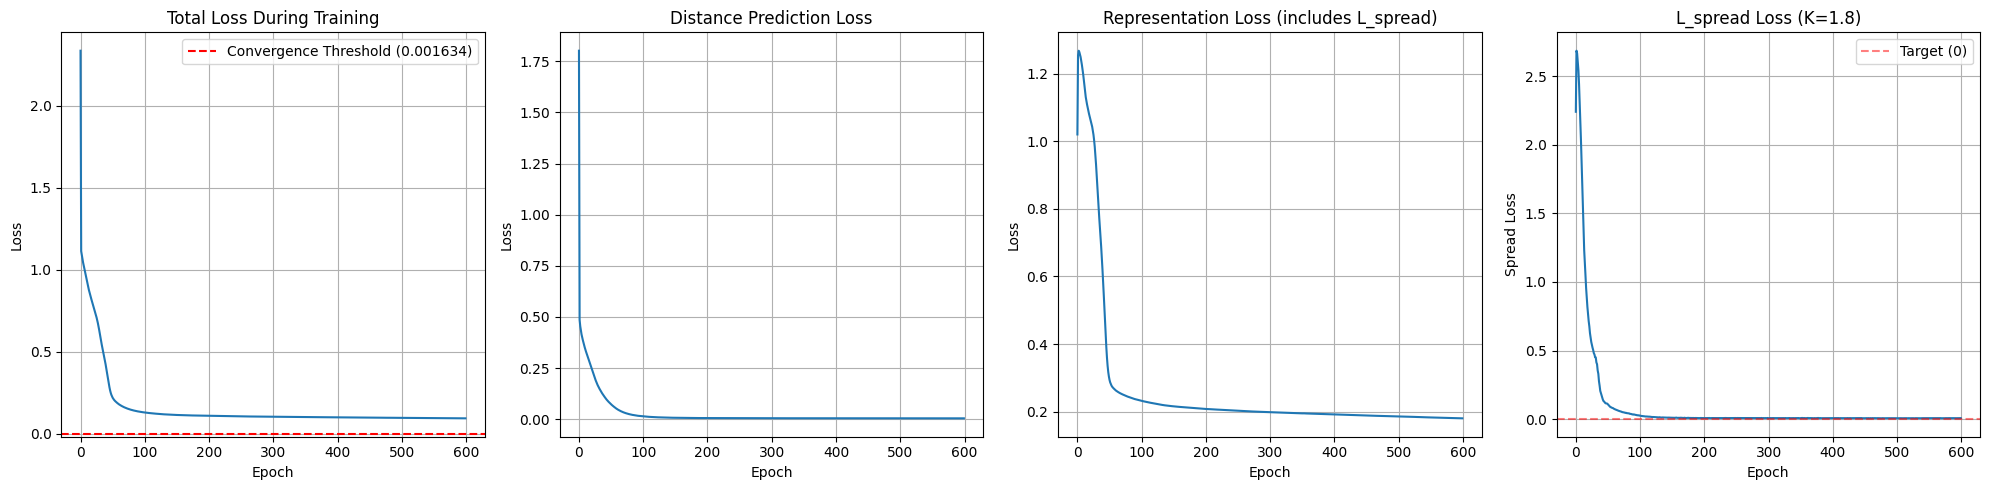

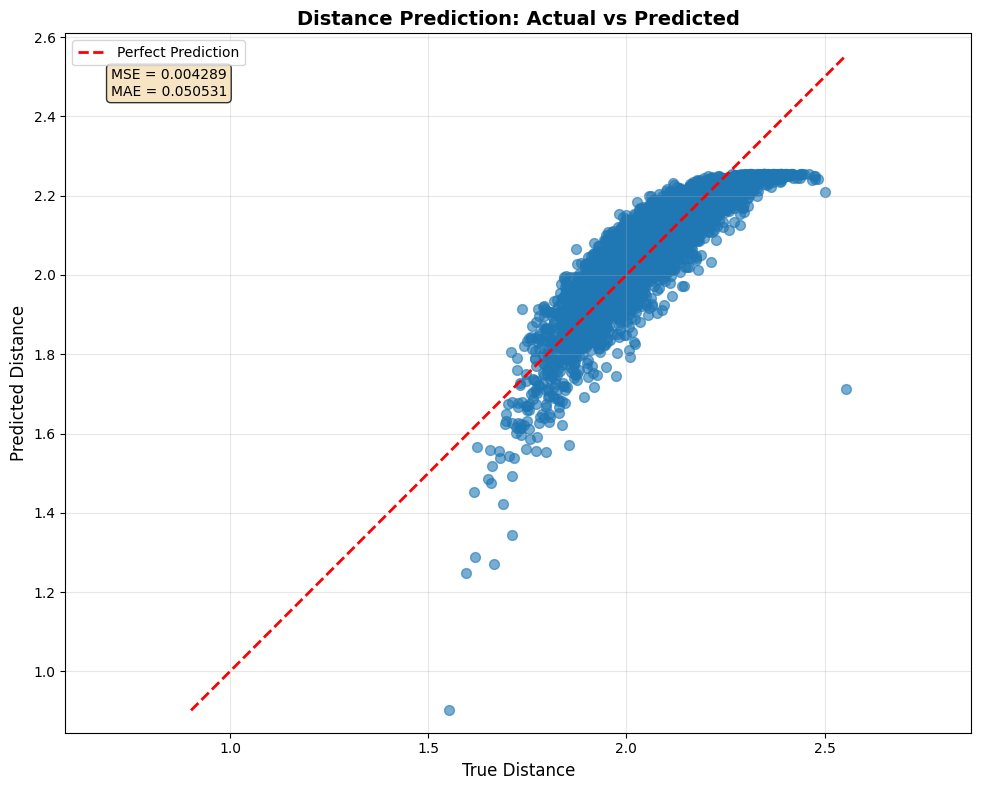

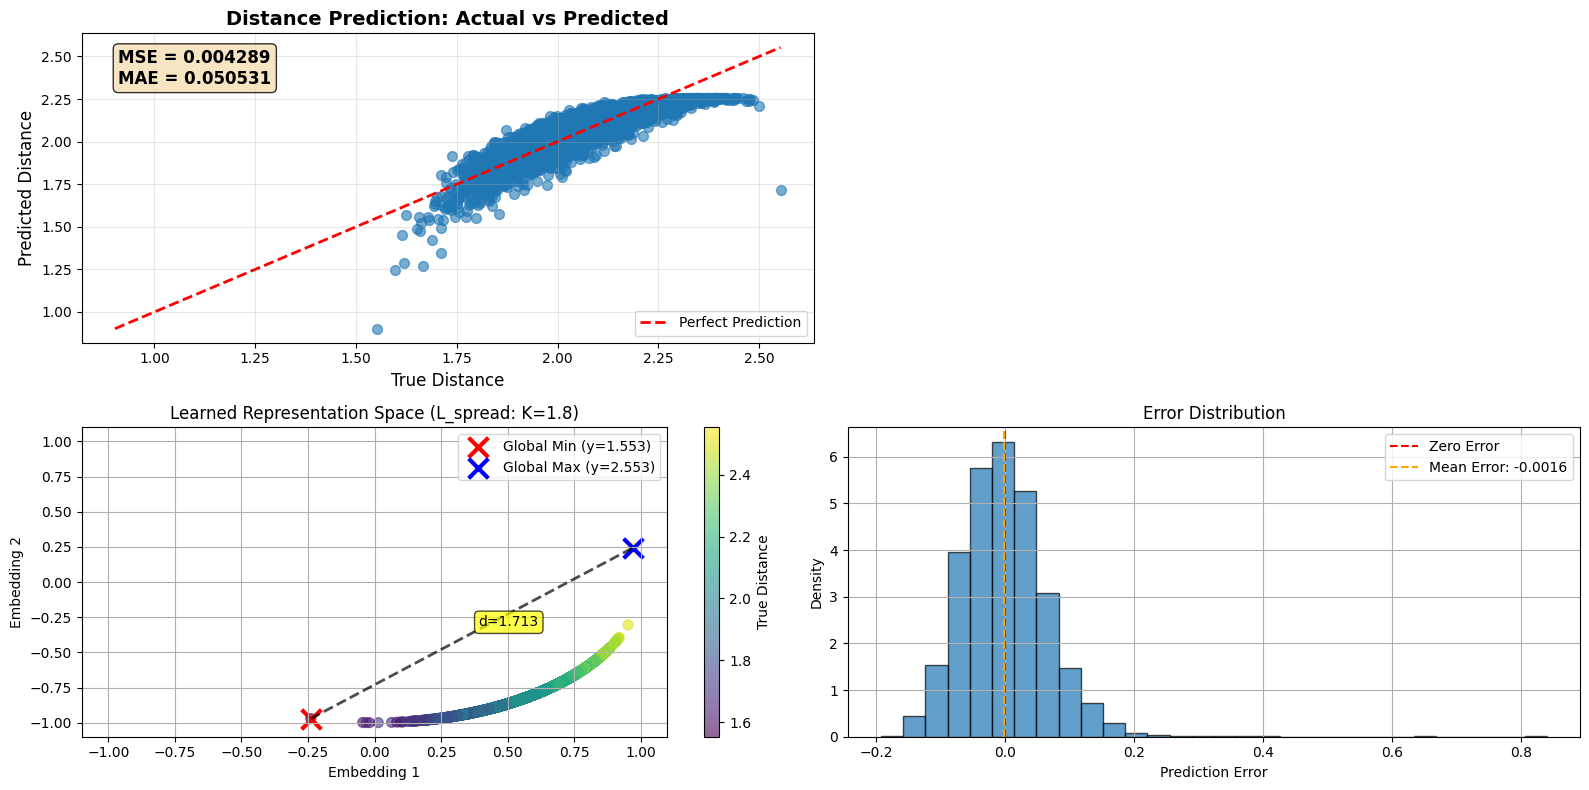

Global min: idx=299, value=1.609034
Global max: idx=204, value=2.481819
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step

Test Set Performance:
Test Pairwise Correlation: 0.0576
Test Distance Prediction MAE: 0.054300


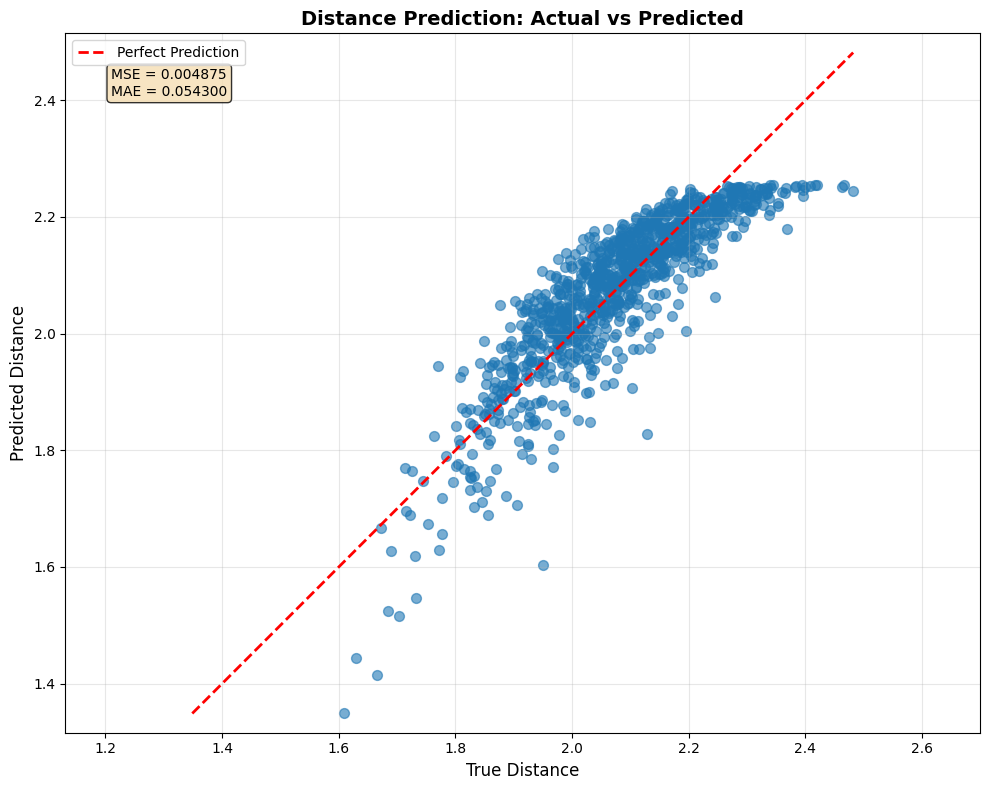

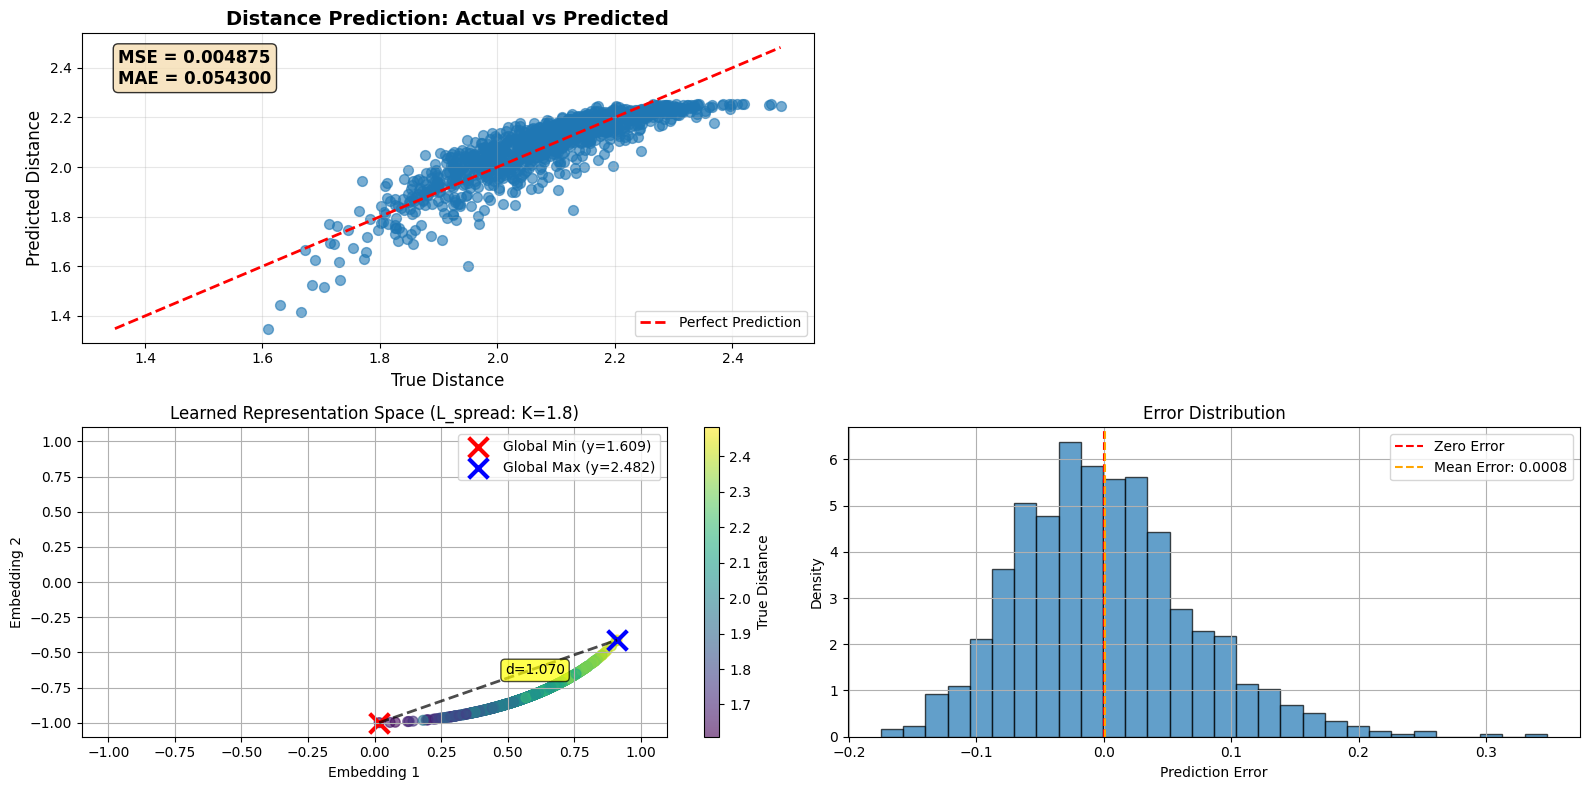

In [18]:
def custom_loss_wrapper(y_true, y_pred):
    """
    Wrapper for PDC loss that handles the representation learning task.
    This should be used when applying PDC loss to representations.
    """
    # The PDC loss expects labels to be [batch_size, 1], but we're using it for 
    # representation learning where y_true are the input features [batch_size, 2]
    # We need to compute distances from the input features to use as labels
    
    # Compute distances from origin for each point in y_true (which are the input features)
    distances = tf.sqrt(tf.reduce_sum(tf.square(y_true), axis=1, keepdims=True))
    
    # Now apply PDC loss with proper shapes
    return mb.pdc_loss_vec(distances, y_pred, pm)

def distance_custom_loss(y_true, y_pred):
    """
    Custom loss for distance prediction task.
    y_true: true distances [batch_size, 1]
    y_pred: predicted distances [batch_size, 1]
    """
    # For distance prediction, we might want to use PDC loss as well
    # or just stick with MSE
    return tf.keras.losses.mse(y_true, y_pred)

# Create trainer with L_spread enabled
trainer = TrainerV4_2(
    input_dim=16, 
    hidden_dims=[8, 16, 32, 16, 8], 
    embed_dim=2, 
    use_normalize_layer=True,
    use_Lspread=True,  # Enable L_spread
    K=1.8  # Target distance between min/max embeddings
)

# Train with L_spread (computed at every iteration)
history, distance_metrics, correlation, distance_predictions, representation_predictions, X_train, y_distance = trainer.train(
    representation_loss_fn=custom_loss_wrapper,
    distance_loss_weight=1.0,
    representation_loss_weight=0.5,
    spread_loss_weight=0.1,  # Weight for L_spread term
    num_points=5000, 
    noise_level=0.15, 
    epochs=600, 
    batch_size=1024,
    verbose=0
)

# Print results with new metrics
print(f"Final Pairwise Correlation: {correlation:.4f}")
print(f"Distance Prediction MAE: {distance_metrics['mae']:.6f}")

# Plot training history (now shows both losses)
trainer.plot_training_history(history)

# Plot the main actual vs predicted plot
trainer.plot_actual_vs_predicted(y_distance, distance_predictions)

# Plot comprehensive analysis including actual vs predicted
trainer.plot_predictions(X_train, y_distance, distance_predictions, representation_predictions)

# Generate test data and evaluate
X_test, y_test = trainer.generate_synthetic_data(num_points=1000, noise_level=0.15)
test_predictions = trainer.model.predict(X_test)
test_distance_predictions = test_predictions[0]
test_representation_predictions = test_predictions[1]

# Evaluate on test data
test_distance_metrics = trainer.compute_distance_metrics(y_test, test_distance_predictions)
test_correlation = trainer.compute_pairwise_correlation(X_test, test_representation_predictions)

print(f"\nTest Set Performance:")
print(f"Test Pairwise Correlation: {test_correlation:.4f}")
print(f"Test Distance Prediction MAE: {test_distance_metrics['mae']:.6f}")

# Plot test results
trainer.plot_actual_vs_predicted(y_test, test_distance_predictions)
trainer.plot_predictions(X_test, y_test, test_distance_predictions, test_representation_predictions)

In [6]:
import tensorflow as tf
import numpy as np

def lcf_loss_vec(y_true, y_pred):
    """
    Vectorized Less Correlated Features loss - squared PCC between all pairs of feature dimensions.
    
    Args:
        y_pred: shape (batch_size, embed_dim)
        y_true: not used, kept for compatibility with Keras loss interface
        
    Returns:
        Mean squared Pearson correlation between all pairs of feature dimensions
        
    Complexity: O(embed_dim^2) - no upper triangle extraction for speed
    """
    # Transpose to work with feature dimensions as rows
    features = tf.transpose(y_pred)  # Shape: (embed_dim, batch_size)
    embed_dim = tf.shape(features)[0]
    batch_size = tf.cast(tf.shape(features)[1], tf.float32)
    
    # Center the features
    means = tf.reduce_mean(features, axis=1, keepdims=True)  # Shape: (embed_dim, 1)
    centered = features - means  # Shape: (embed_dim, batch_size)
    
    # Compute covariance matrix: cov[i,j] = mean((f_i - mean_i) * (f_j - mean_j))
    cov_matrix = tf.matmul(centered, centered, transpose_b=True) / batch_size
    
    # Compute standard deviations and correlation matrix
    variances = tf.reduce_mean(tf.square(centered), axis=1)  # Shape: (embed_dim,)
    std_devs = tf.sqrt(variances + 1e-8)
    
    # Compute outer product using broadcasting instead of tf.outer
    std_outer = tf.expand_dims(std_devs, 1) * tf.expand_dims(std_devs, 0)  # Shape: (embed_dim, embed_dim)
    corr_matrix = cov_matrix / (std_outer + 1e-8)
    
    # Square correlations and exclude diagonal (self-correlations = 1)
    corr_squared = tf.square(corr_matrix) * (1.0 - tf.eye(embed_dim))
    
    # Mean over all off-diagonal pairs (counts each pair twice due to symmetry)
    return tf.reduce_sum(corr_squared) / tf.cast(embed_dim * (embed_dim - 1), tf.float32)


# Test function to verify correctness
def test_lcf_loss():
    """Test the vectorized LCF loss against a simple 2D case"""
    
    # Create test data: batch_size=4, embed_dim=3
    np.random.seed(42)
    test_data = tf.constant([
        [1.0, 2.0, 3.0],  # instance 1: (1, 2)
        [1.5, 2.2, 3.1],  # instance 2: (1.5, 2.2) 
        [0.8, 1.9, 2.8],  # instance 3: (0.8, 1.9)
        [1.2, 2.1, 3.2],  # instance 4: (1.2, 2.1)
    ], dtype=tf.float32)
    
    # Compute LCF loss
    loss = lcf_loss_vec(None, test_data)
    
    print("Test Data:")
    print("Instance 1: [1.0, 2.0, 3.0]")
    print("Instance 2: [1.5, 2.2, 3.1]") 
    print("Instance 3: [0.8, 1.9, 2.8]")
    print("Instance 4: [1.2, 2.1, 3.2]")
    print()
    
    print("Feature vectors across instances:")
    print("f1 (dim 1): [1.0, 1.5, 0.8, 1.2]")
    print("f2 (dim 2): [2.0, 2.2, 1.9, 2.1]") 
    print("f3 (dim 3): [3.0, 3.1, 2.8, 3.2]")
    print()
    
    print(f"LCF Loss (vectorized): {loss:.6f}")
    
    # Manual verification for 2D case
    if test_data.shape[1] == 2:  # Only verify for 2D
        f1 = test_data[:, 0]
        f2 = test_data[:, 1]
        
        f1_mean = tf.reduce_mean(f1)
        f2_mean = tf.reduce_mean(f2)
        f1_centered = f1 - f1_mean
        f2_centered = f2 - f2_mean
        
        cov = tf.reduce_mean(f1_centered * f2_centered)
        std1 = tf.sqrt(tf.reduce_mean(tf.square(f1_centered)) + 1e-8)
        std2 = tf.sqrt(tf.reduce_mean(tf.square(f2_centered)) + 1e-8)
        pcc = cov / (std1 * std2 + 1e-8)
        manual_loss = tf.square(pcc)
        
        print(f"Manual 2D calculation: {manual_loss:.6f}")
        print(f"Difference: {abs(loss - manual_loss):.8f}")
    
    return loss

def test_lcf_loss_loop():
    """Test the vectorized LCF loss against a for-loop implementation for arbitrary feature size"""
    np.random.seed(123)
    batch_size = 8
    embed_dim = 5
    data = np.random.randn(batch_size, embed_dim).astype(np.float32)
    tf_data = tf.constant(data)

    # Vectorized loss
    loss_vec = lcf_loss_vec(None, tf_data).numpy()

    # For-loop loss (manual, using numpy)
    means = np.mean(data, axis=0)
    centered = data - means
    stds = np.std(data, axis=0, ddof=0) + 1e-8
    total = 0.0
    count = 0
    for i in range(embed_dim):
        for j in range(embed_dim):
            if i != j:
                cov = np.mean(centered[:, i] * centered[:, j])
                pcc = cov / (stds[i] * stds[j] + 1e-8)
                total += pcc ** 2
                count += 1
    loss_loop = total / count if count > 0 else 0.0

    print("\nFor-loop test (arbitrary feature size):")
    print(f"Vectorized LCF loss: {loss_vec:.8f}")
    print(f"For-loop LCF loss:  {loss_loop:.8f}")
    print(f"Difference:         {abs(loss_vec - loss_loop):.10f}")

    assert np.allclose(loss_vec, loss_loop, atol=1e-6), "Vectorized and loop LCF loss do not match!"

if __name__ == "__main__":
    test_lcf_loss()
    test_lcf_loss_loop()

Test Data:
Instance 1: [1.0, 2.0, 3.0]
Instance 2: [1.5, 2.2, 3.1]
Instance 3: [0.8, 1.9, 2.8]
Instance 4: [1.2, 2.1, 3.2]

Feature vectors across instances:
f1 (dim 1): [1.0, 1.5, 0.8, 1.2]
f2 (dim 2): [2.0, 2.2, 1.9, 2.1]
f3 (dim 3): [3.0, 3.1, 2.8, 3.2]

LCF Loss (vectorized): 0.756687

For-loop test (arbitrary feature size):
Vectorized LCF loss: 0.14021841
For-loop LCF loss:  0.14021841
Difference:         0.0000000000
